# Notes

# Update

## 02/16/2024

<figure>
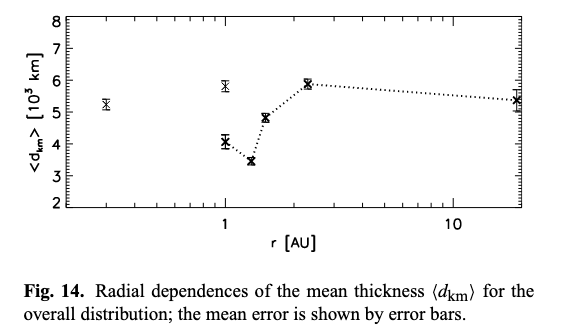
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

-   Normalization of the daily rates to 400 km/s ?

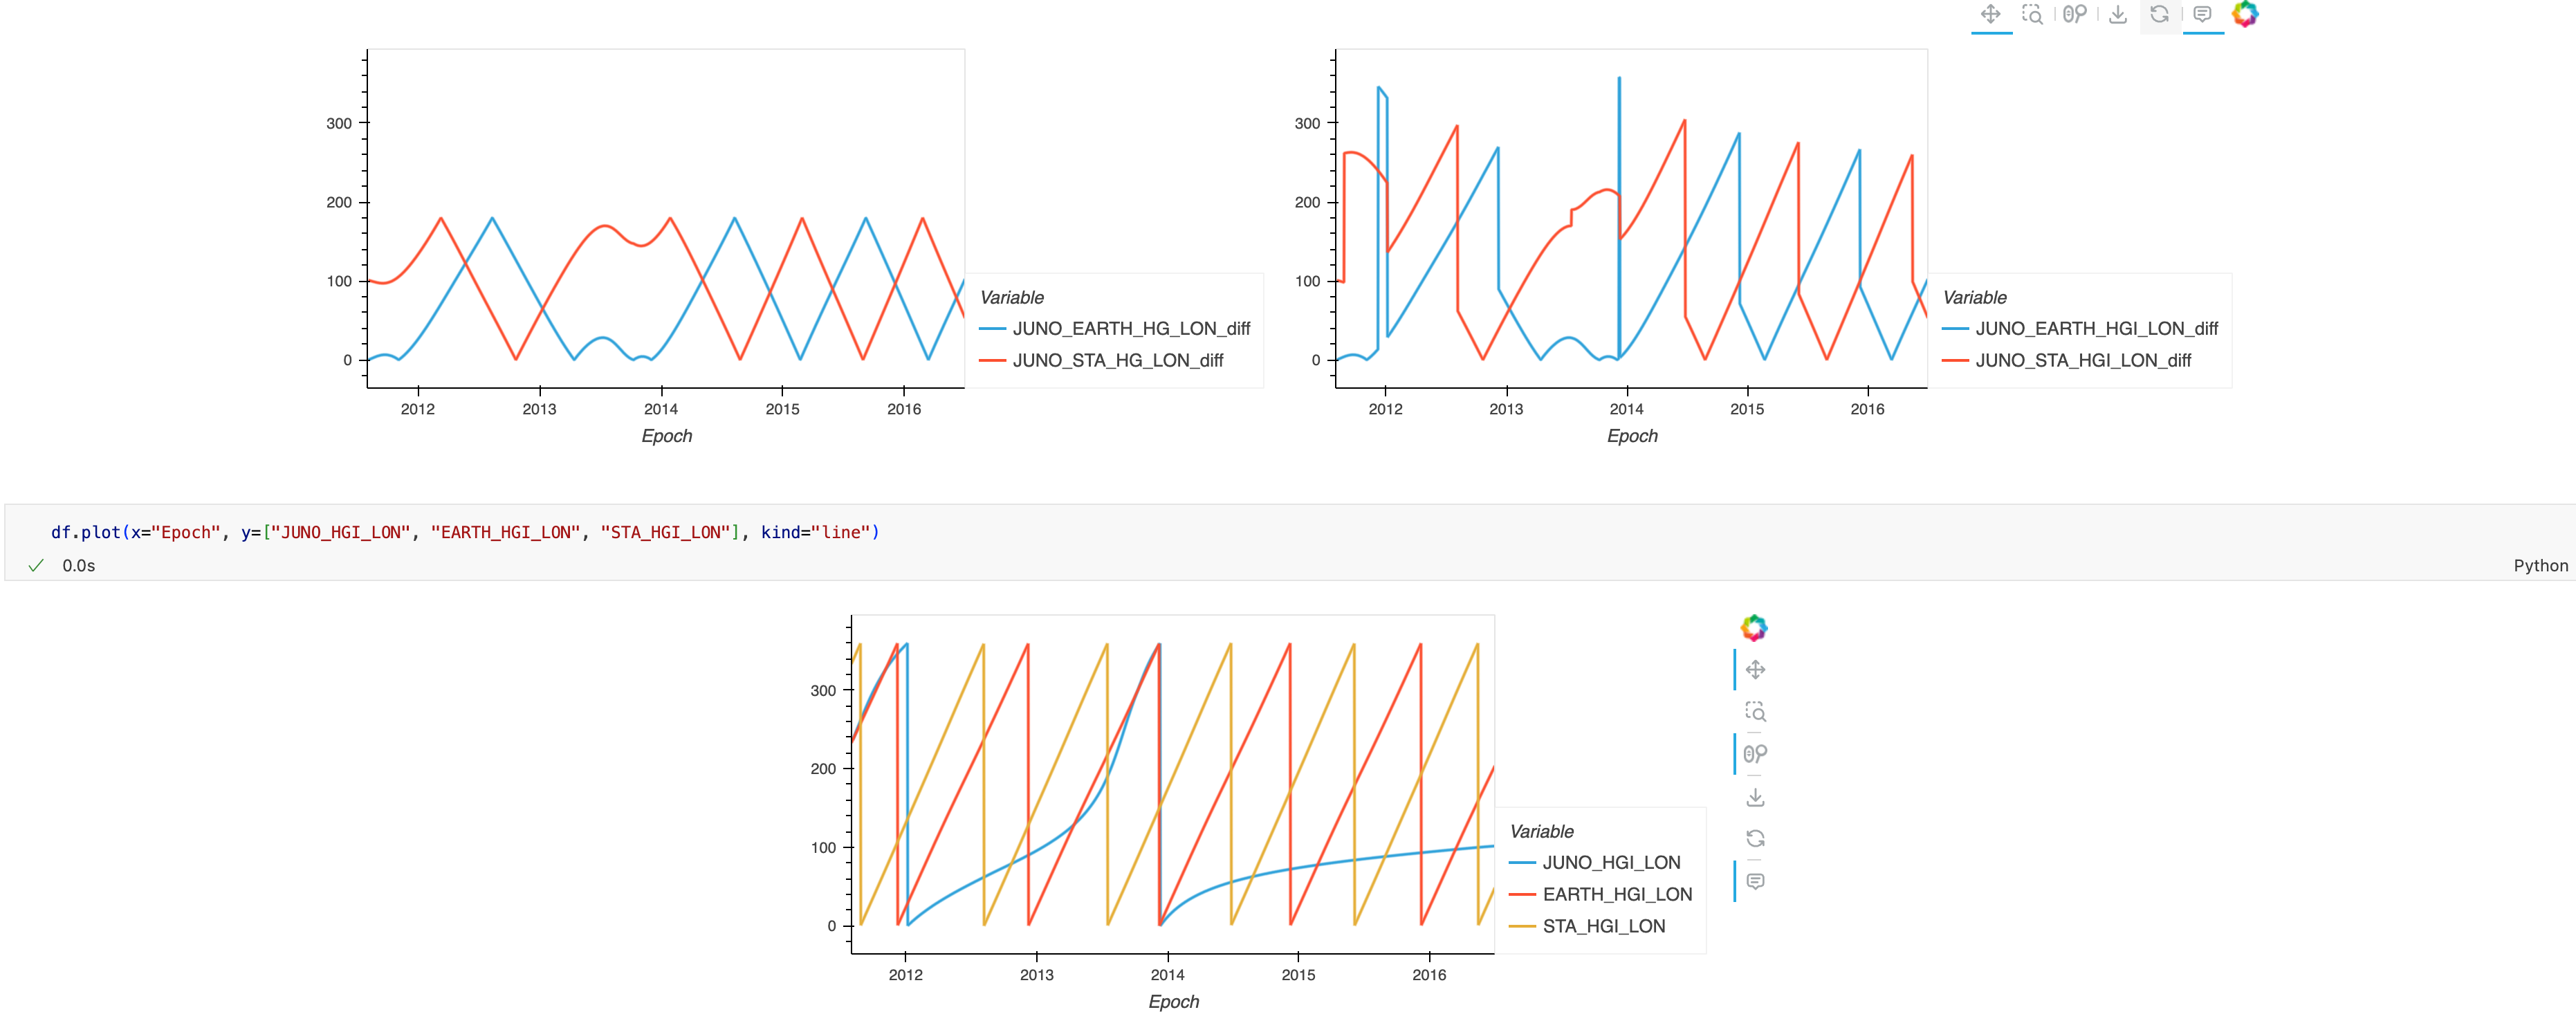

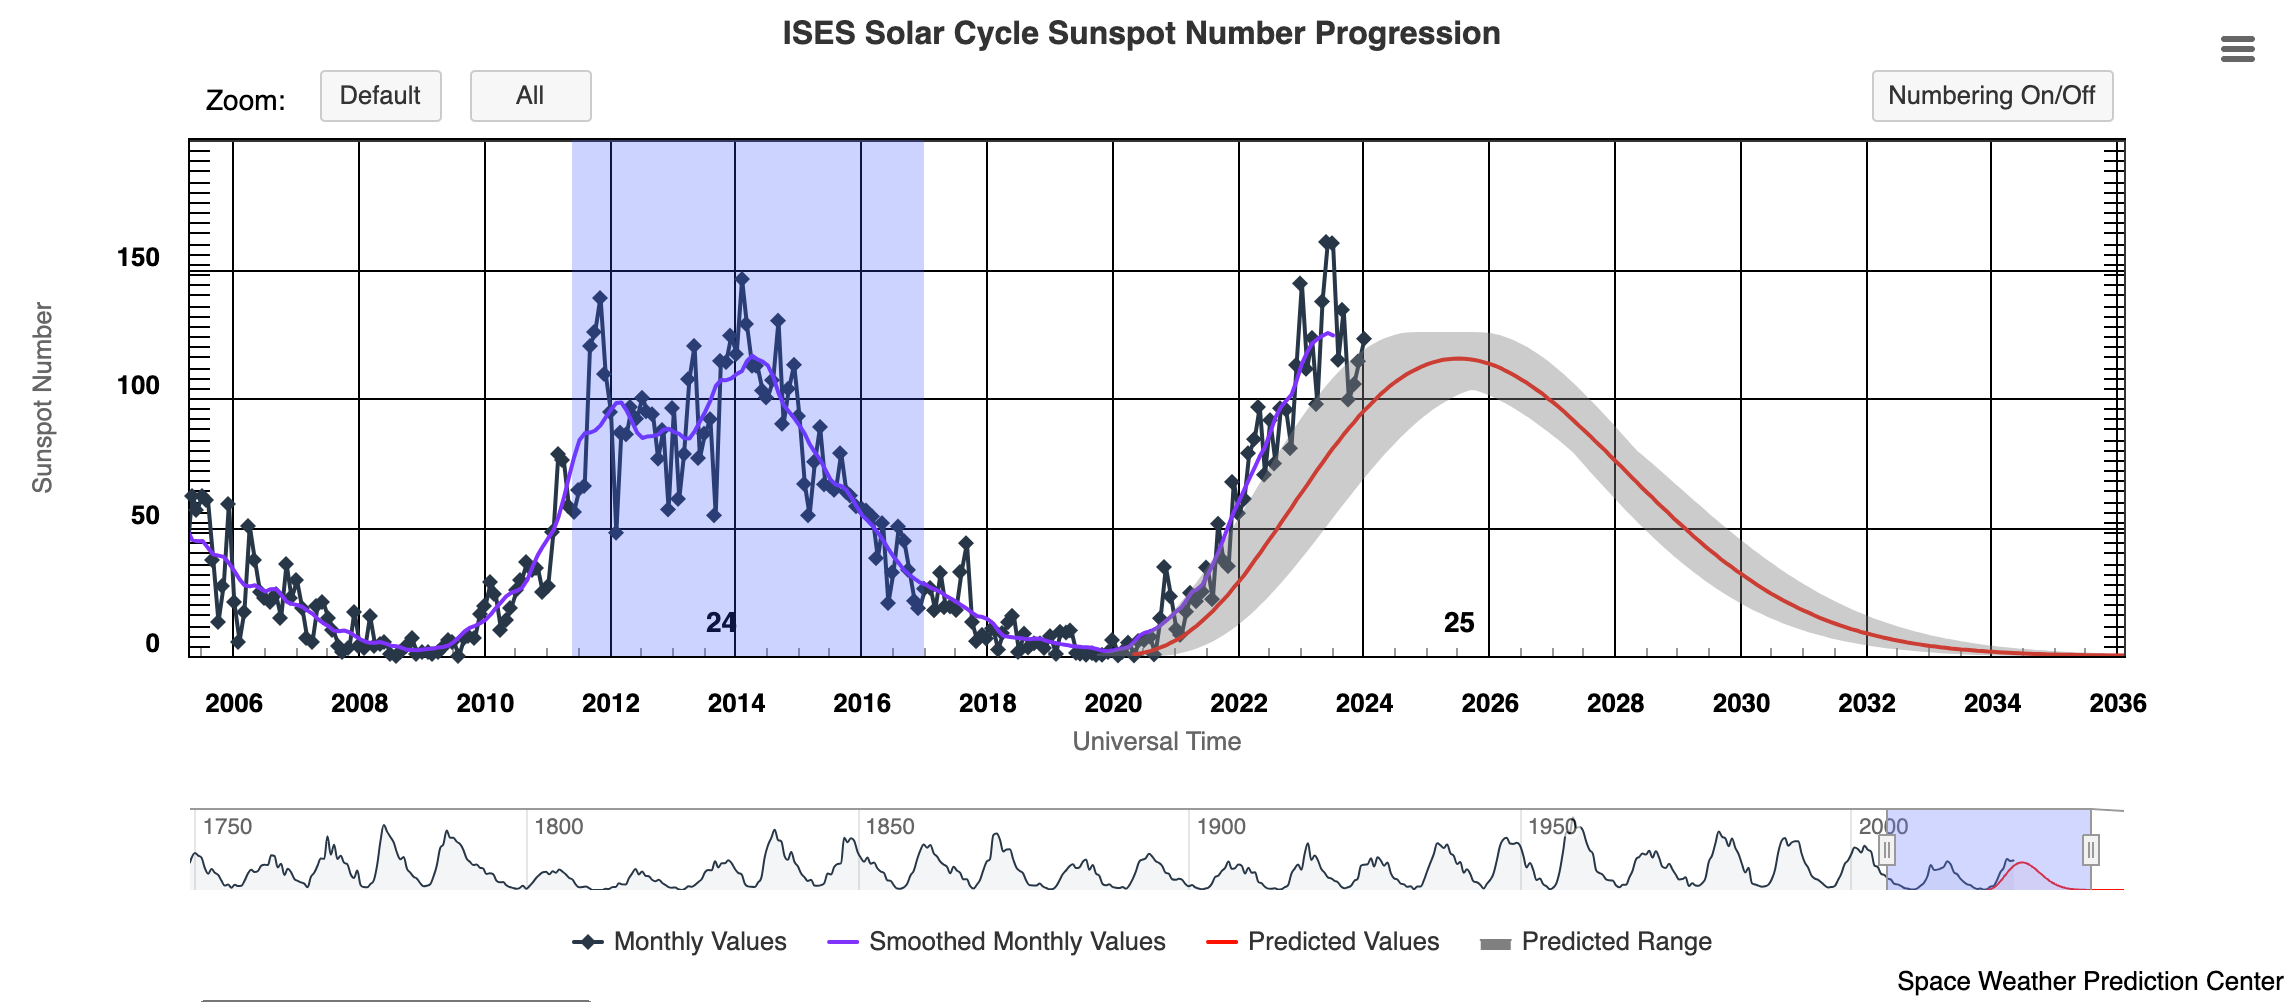

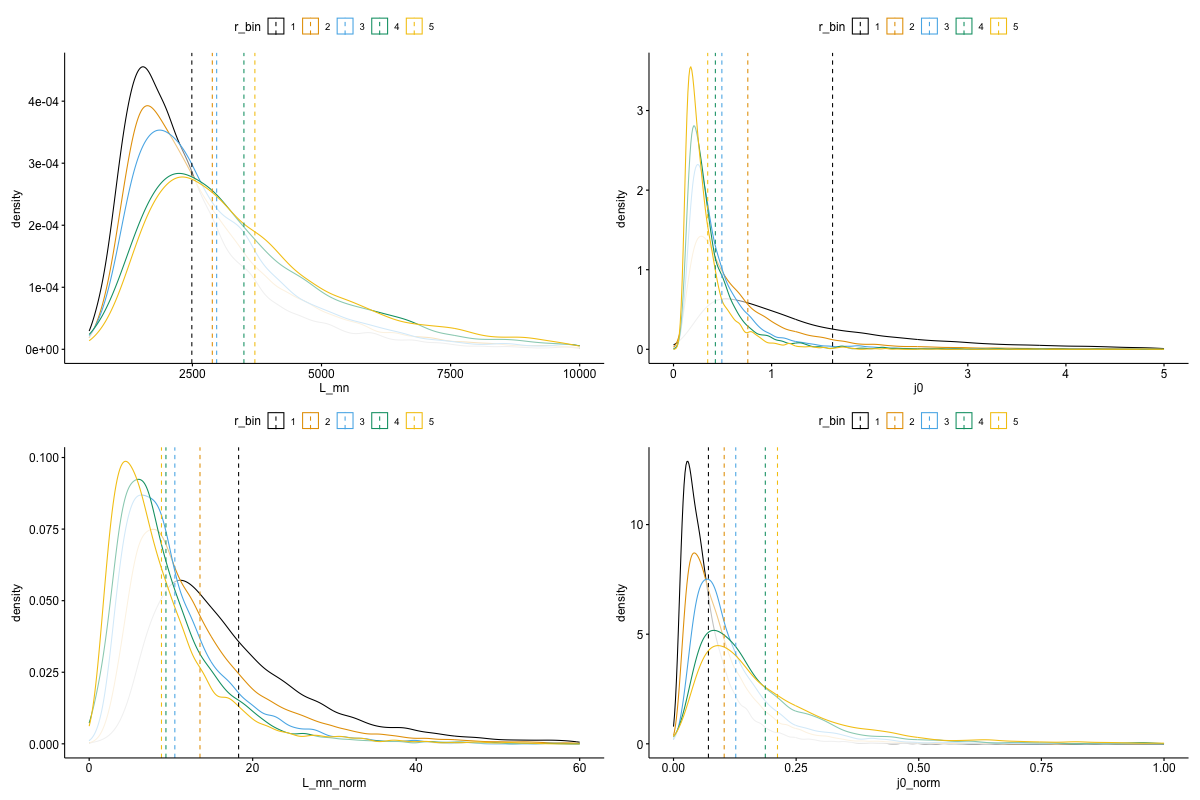

# Motivations

Studying the radial distribution of occurrence rate, as well as the properties of solar wind discontinuities may help answer the following questions:

-   How does the discontinuities change with the radial distance from the Sun?
-   How is solar wind discontinuities formed? What is the physical mechanisms?
    -   Generated at or near the sun?
    -   Locally generated in the interplanetary space by turbulence?

Joint observations of JUNO & ARTEMIS & Other missions really provides a unique opportunity!!!

![](https://www.nasa.gov/wp-content/uploads/2023/03/575573main_Juno20110727-3-43_full.jpg)

<https://www.youtube.com/watch?v=sYp5p2oL51g>

-   Five-year cruise to Jupiter from 2011 to 2016
-   One earth flyby in 2013
-   Nearly the same Heliographic latitude as Earth

To eliminate the effect of the solar wind structure, we use data from other missions (mainly at 1AU) to provide a way of normalization.

## Solar Wind Model

Sadly, JUNO does not provide plasma data during the cruise phase, so to estimate the plasma state we will use MHD model.

We are using [Michigan Solar WInd Model 2D (MSWIM2D)](http://csem.engin.umich.edu/MSWIM2D/), which models the solar wind propagation in 2D using the BATSRUS MHD solver. Keebler et al. (2022)

Some key points about the model

-   Representing the solar wind in the ecliptic plane from 1 to 75 AU
-   2D MHD model, using the BATSRUS MHD solver
-   Inclusion of neutral hydrogen (important for the outer heliosphere)
-   Inner boundary is filled by time-shifting in situ data from multiple spacecraft

For model validation part, please see [JUNO Model Report](notebooks/20_model.ipynb).

# Properties

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: center;"><div width="50.0%" data-layout-align="center">
<p>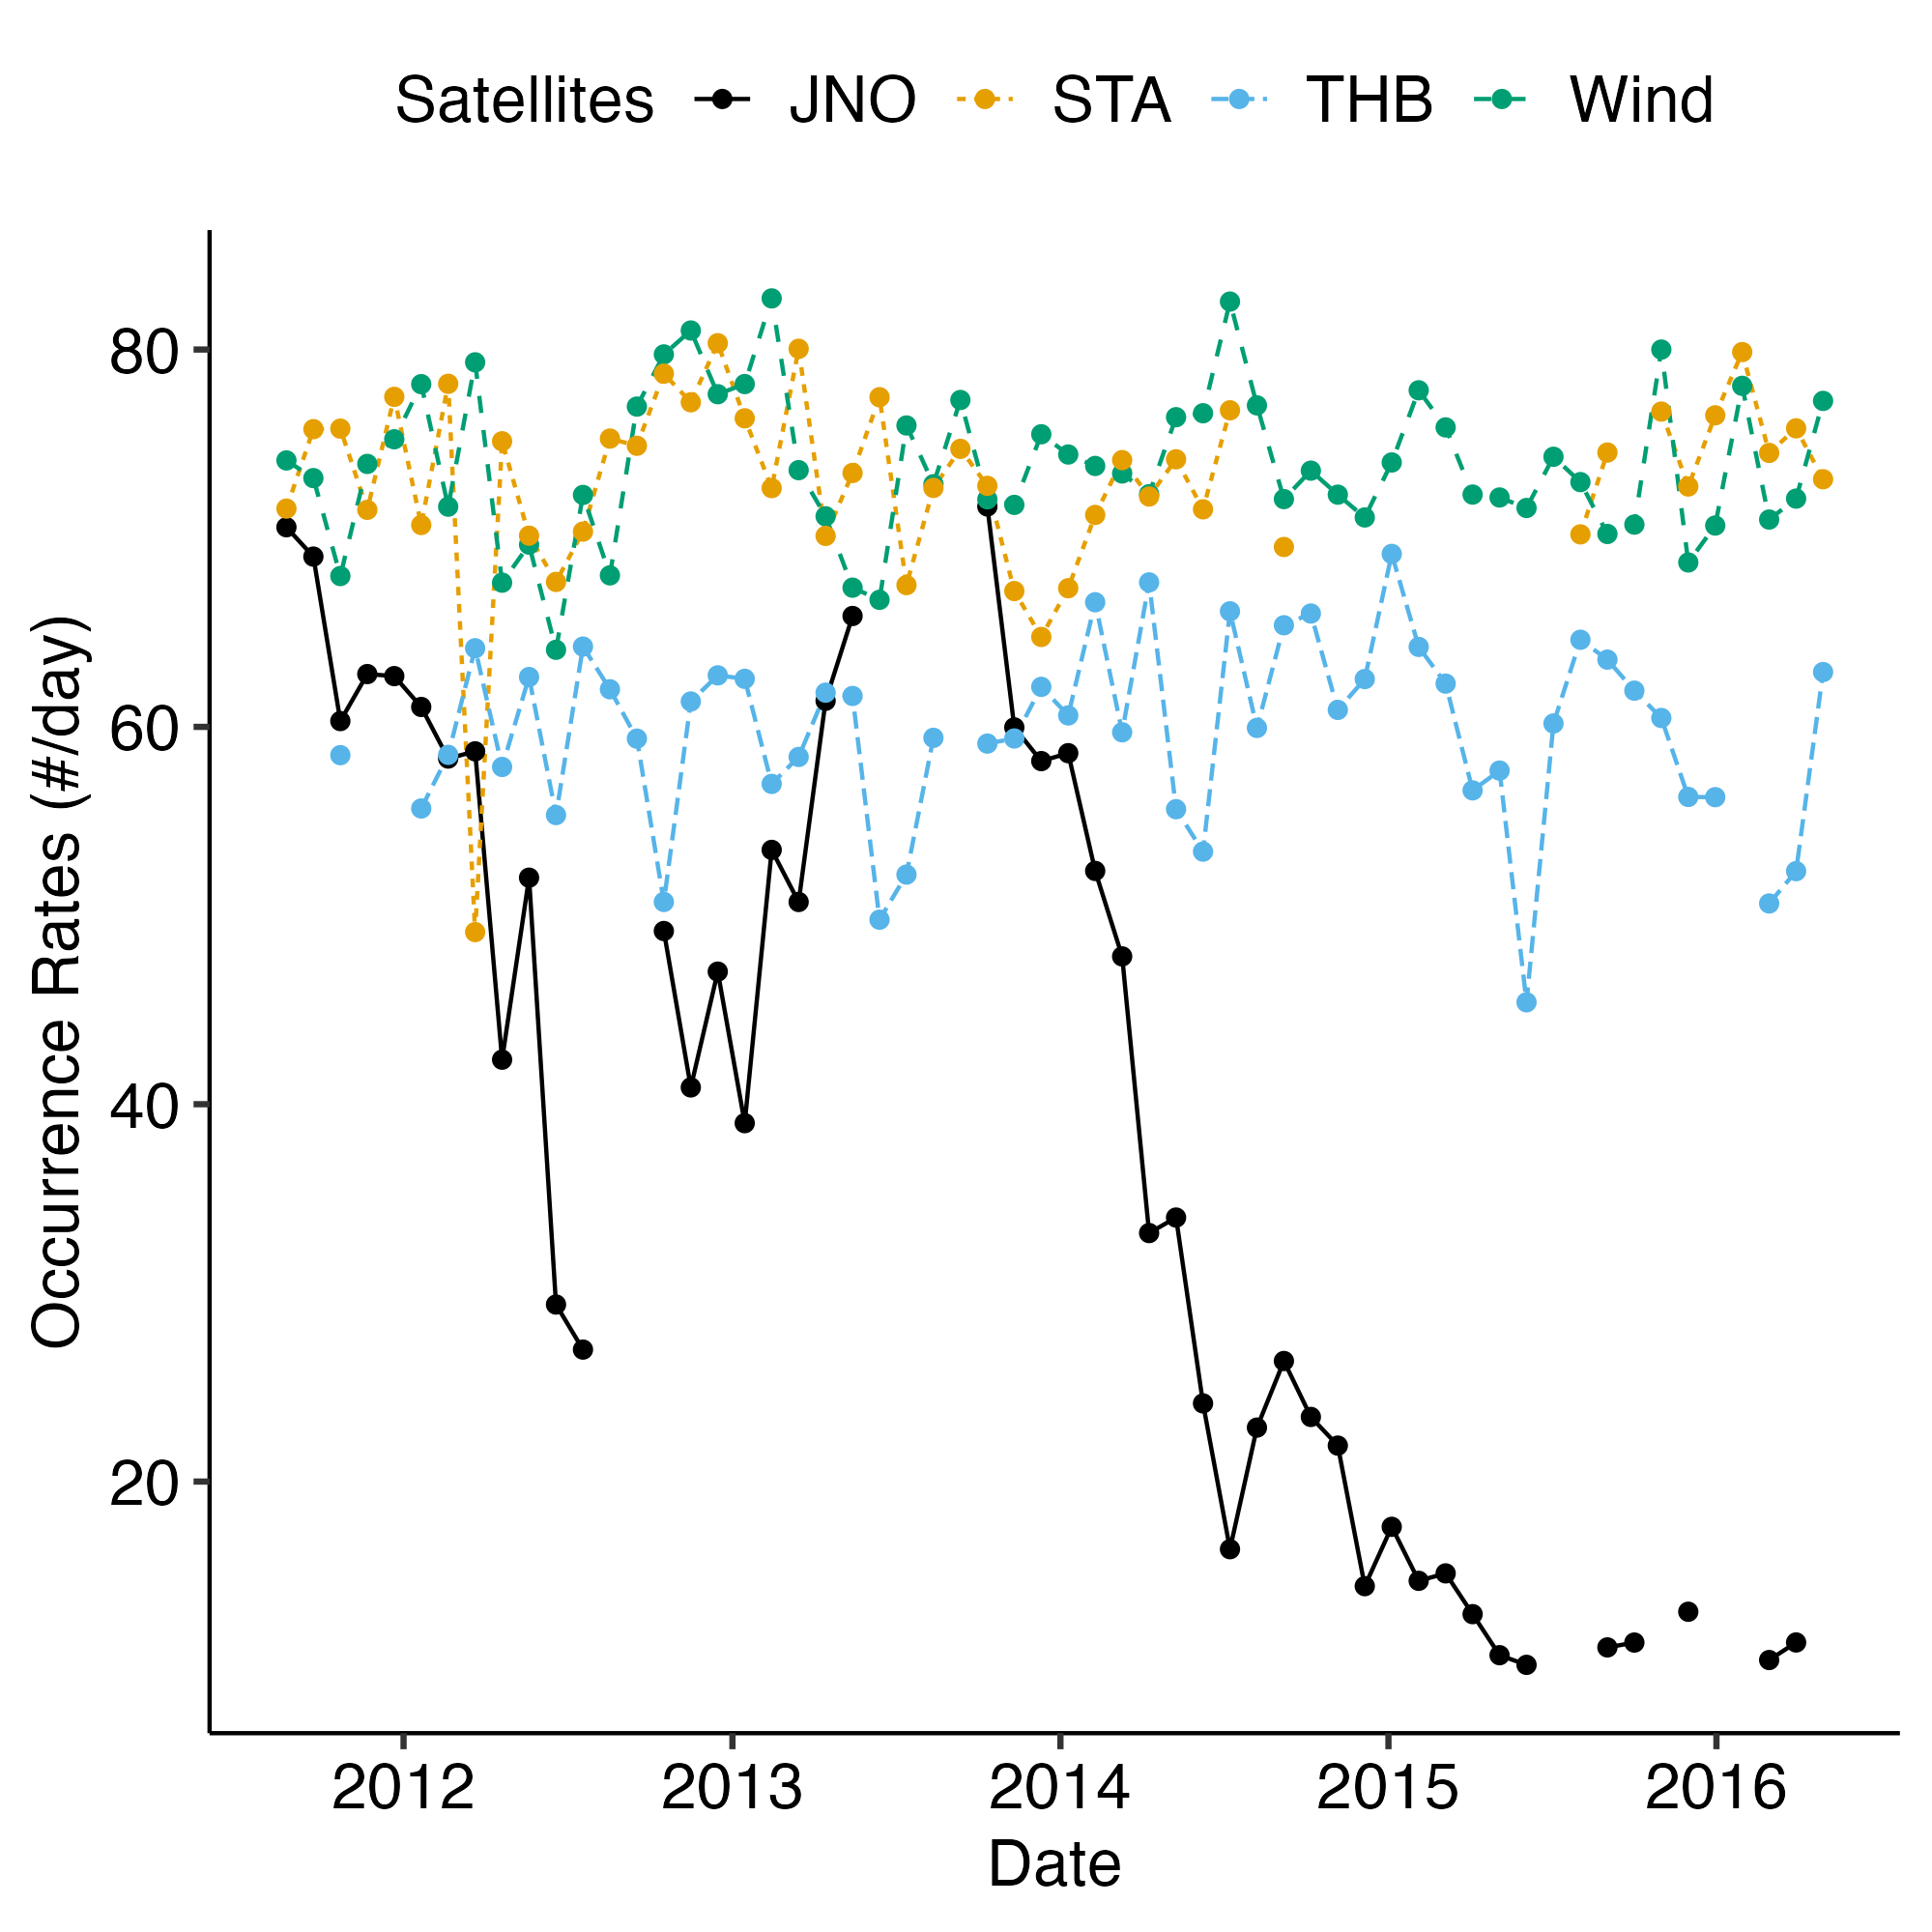</p>
</div></td>
<td style="text-align: center;"><div width="50.0%" data-layout-align="center">
<p>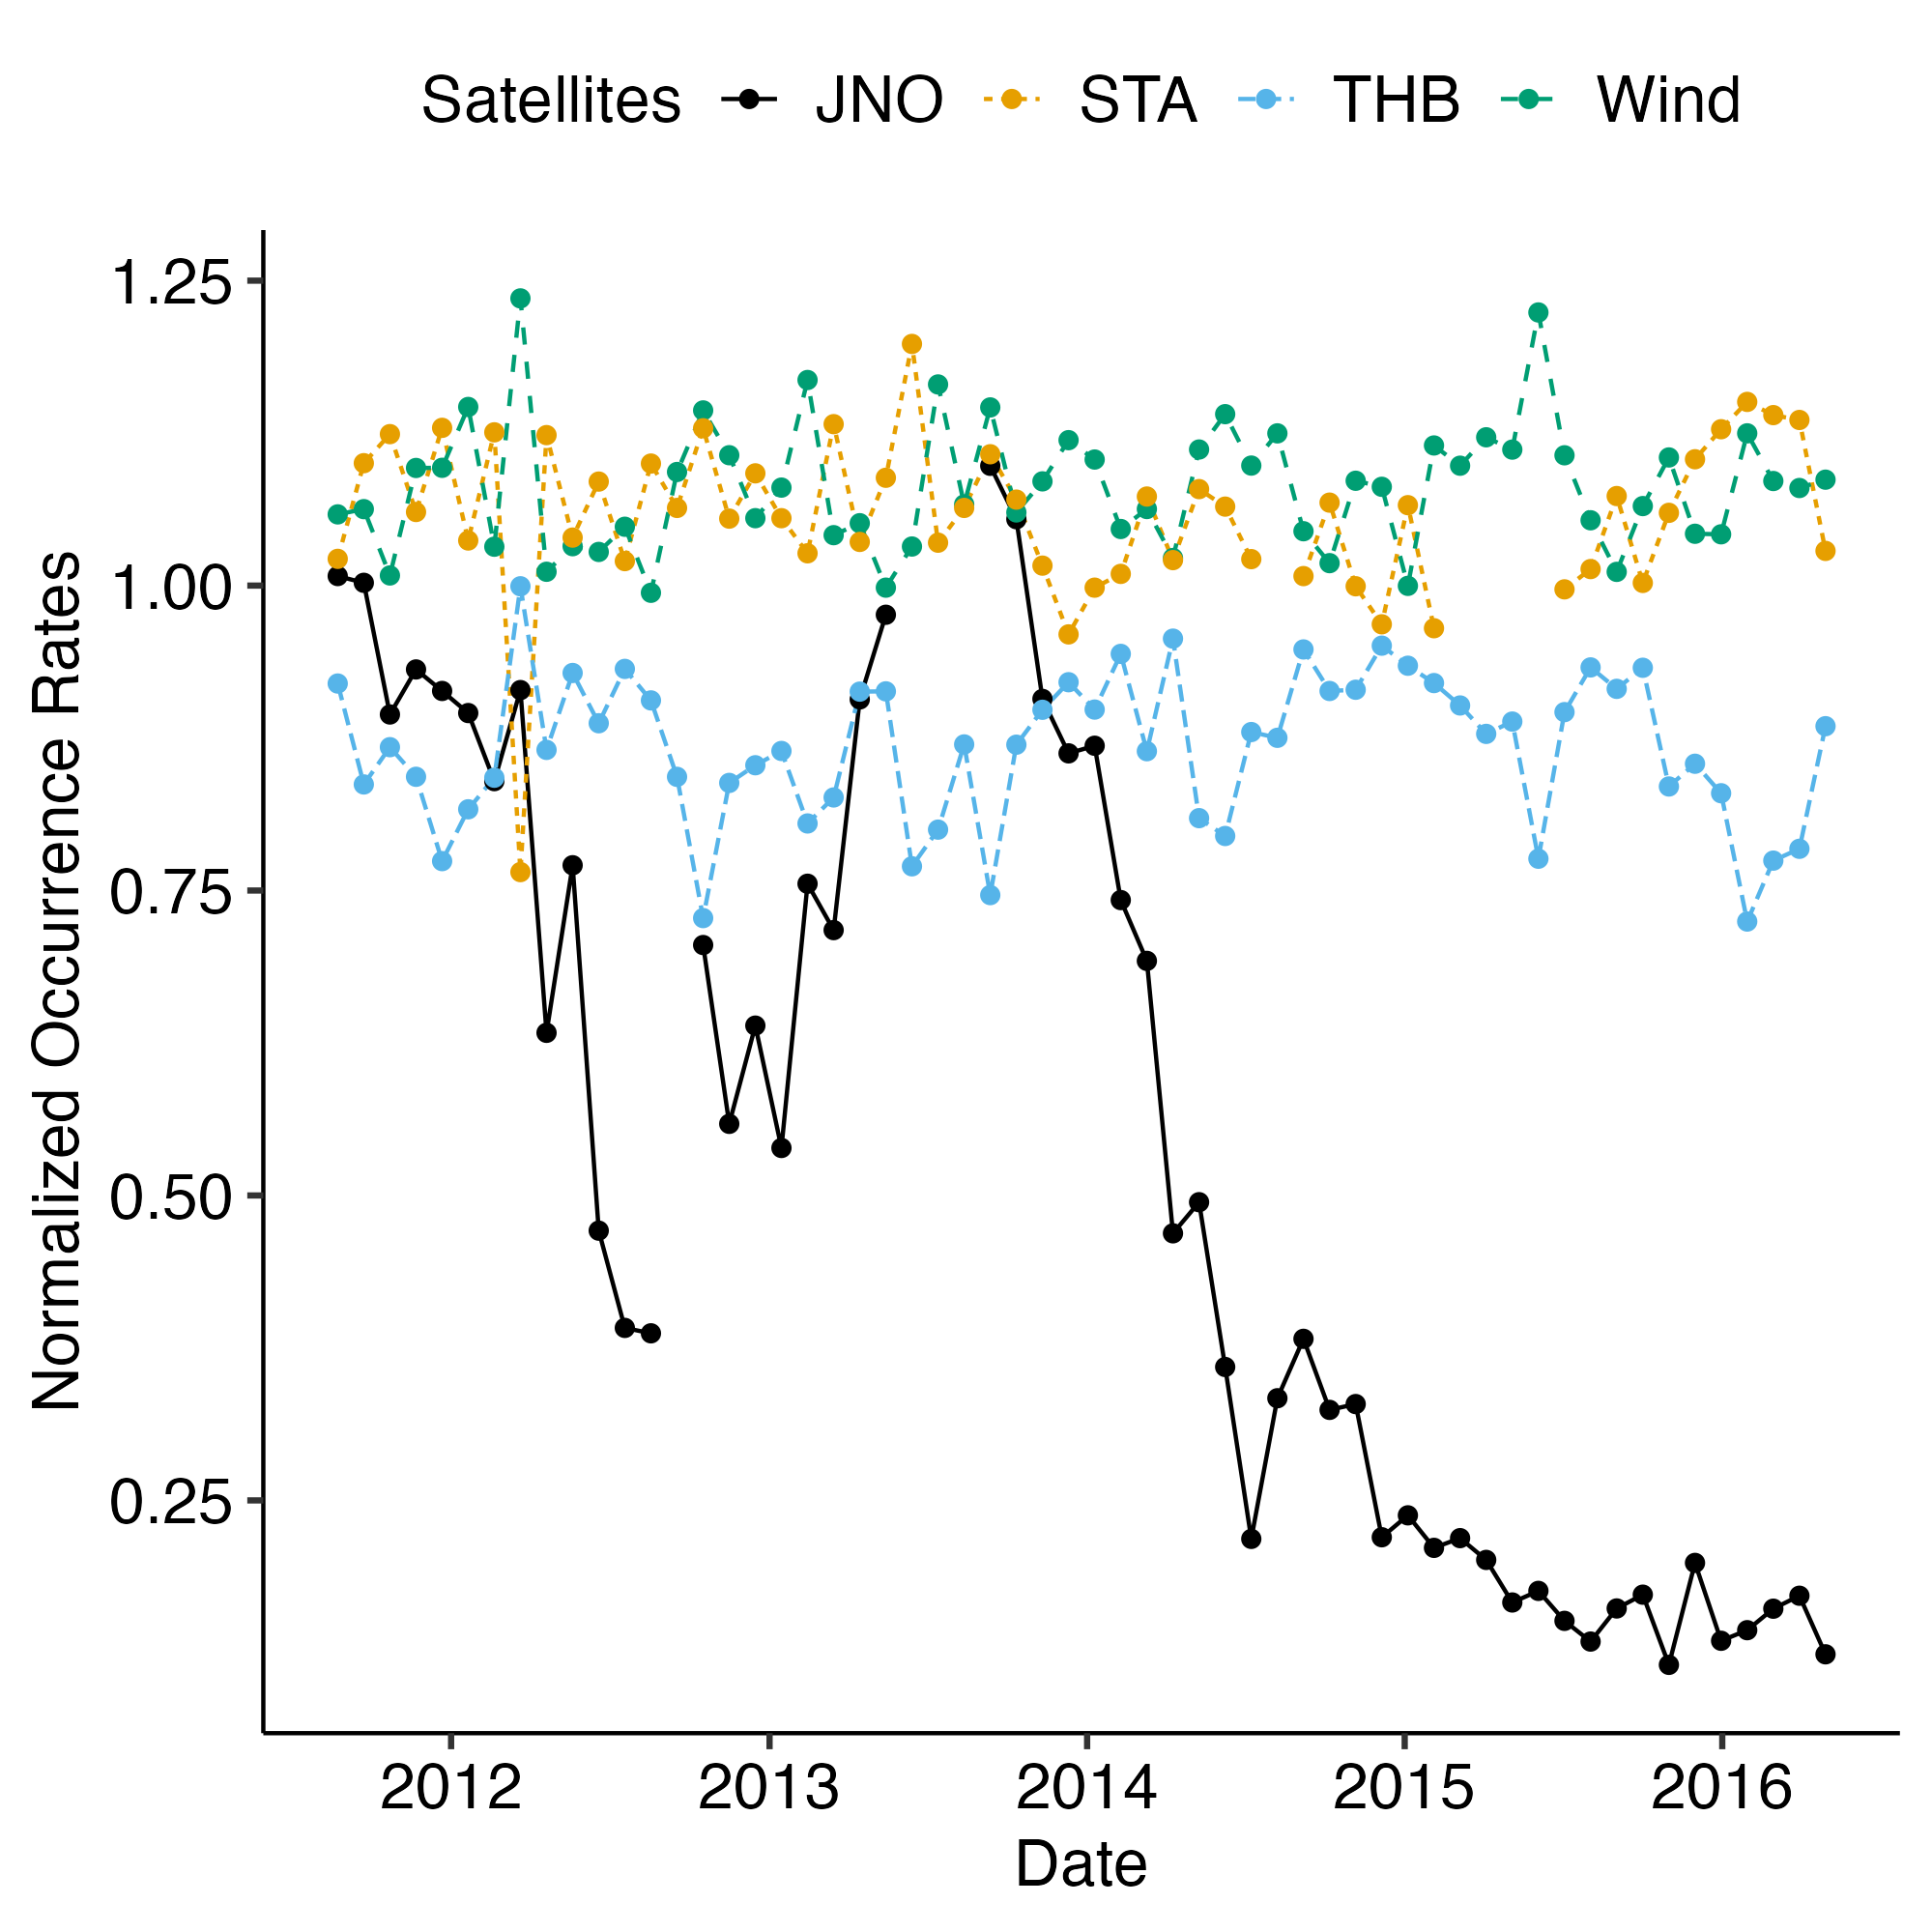</p>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: center;"><div width="50.0%" data-layout-align="center">
<p>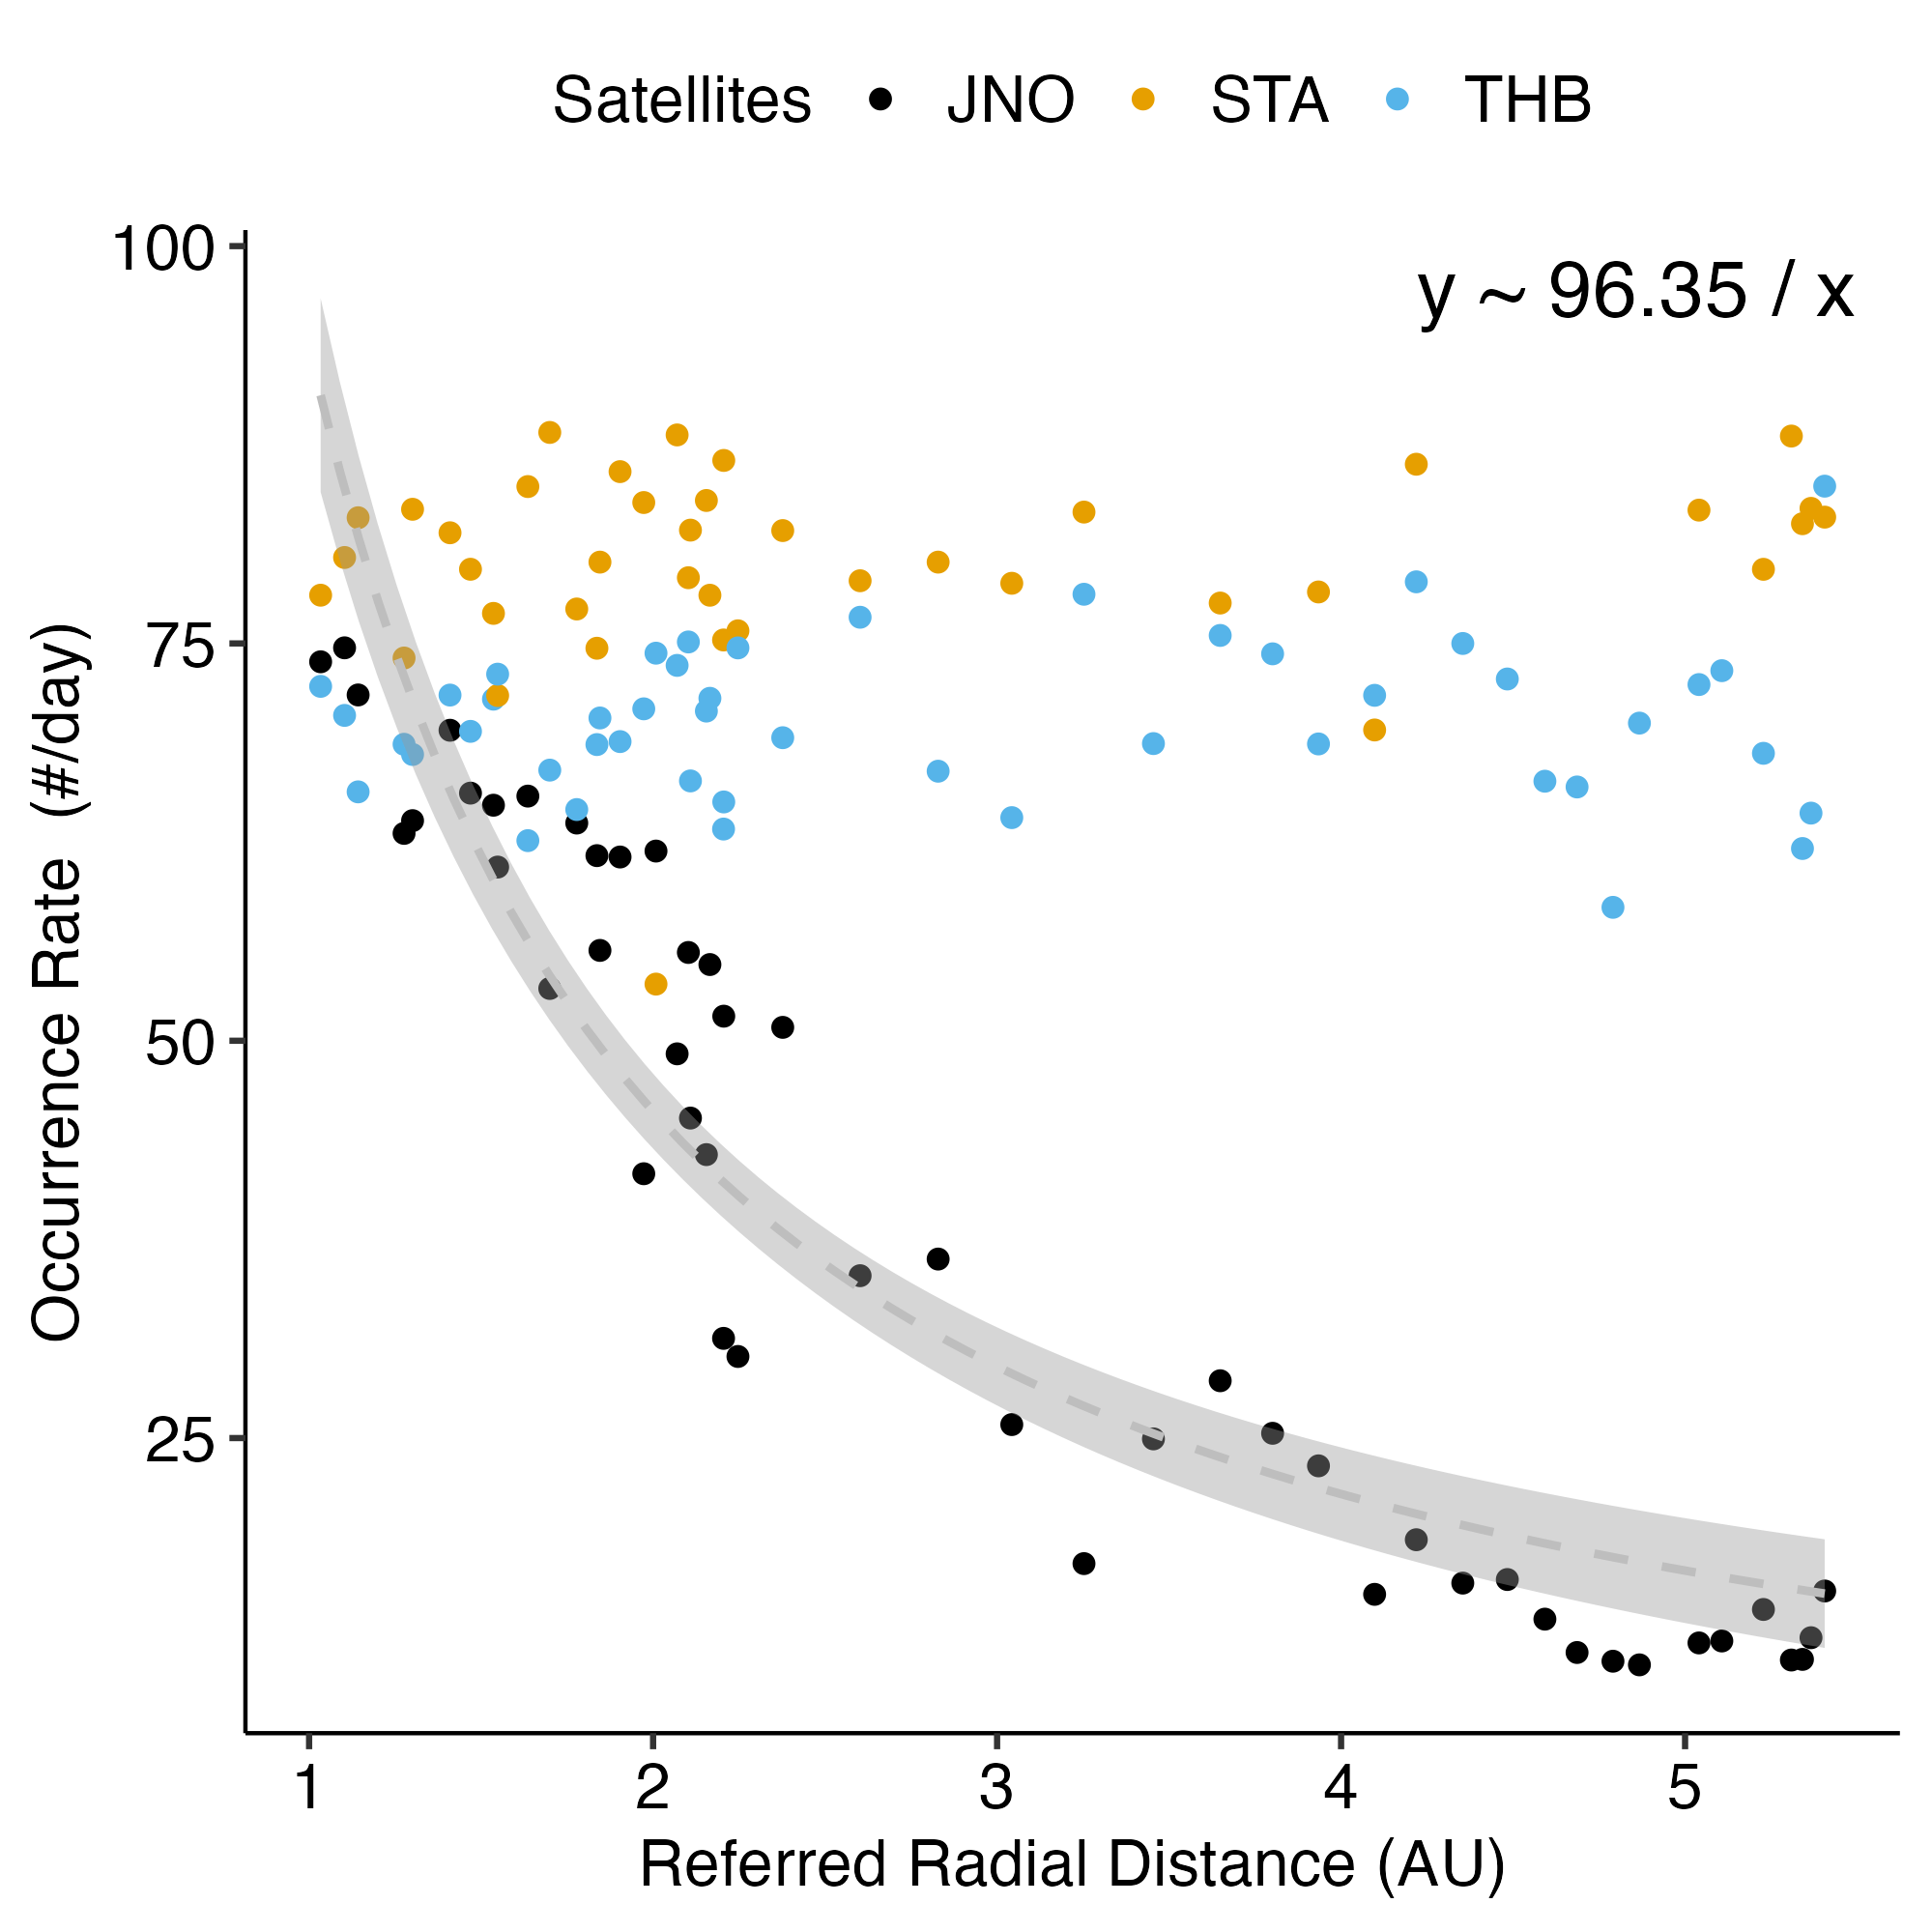</p>
</div></td>
<td style="text-align: center;"><div width="50.0%" data-layout-align="center">
<p>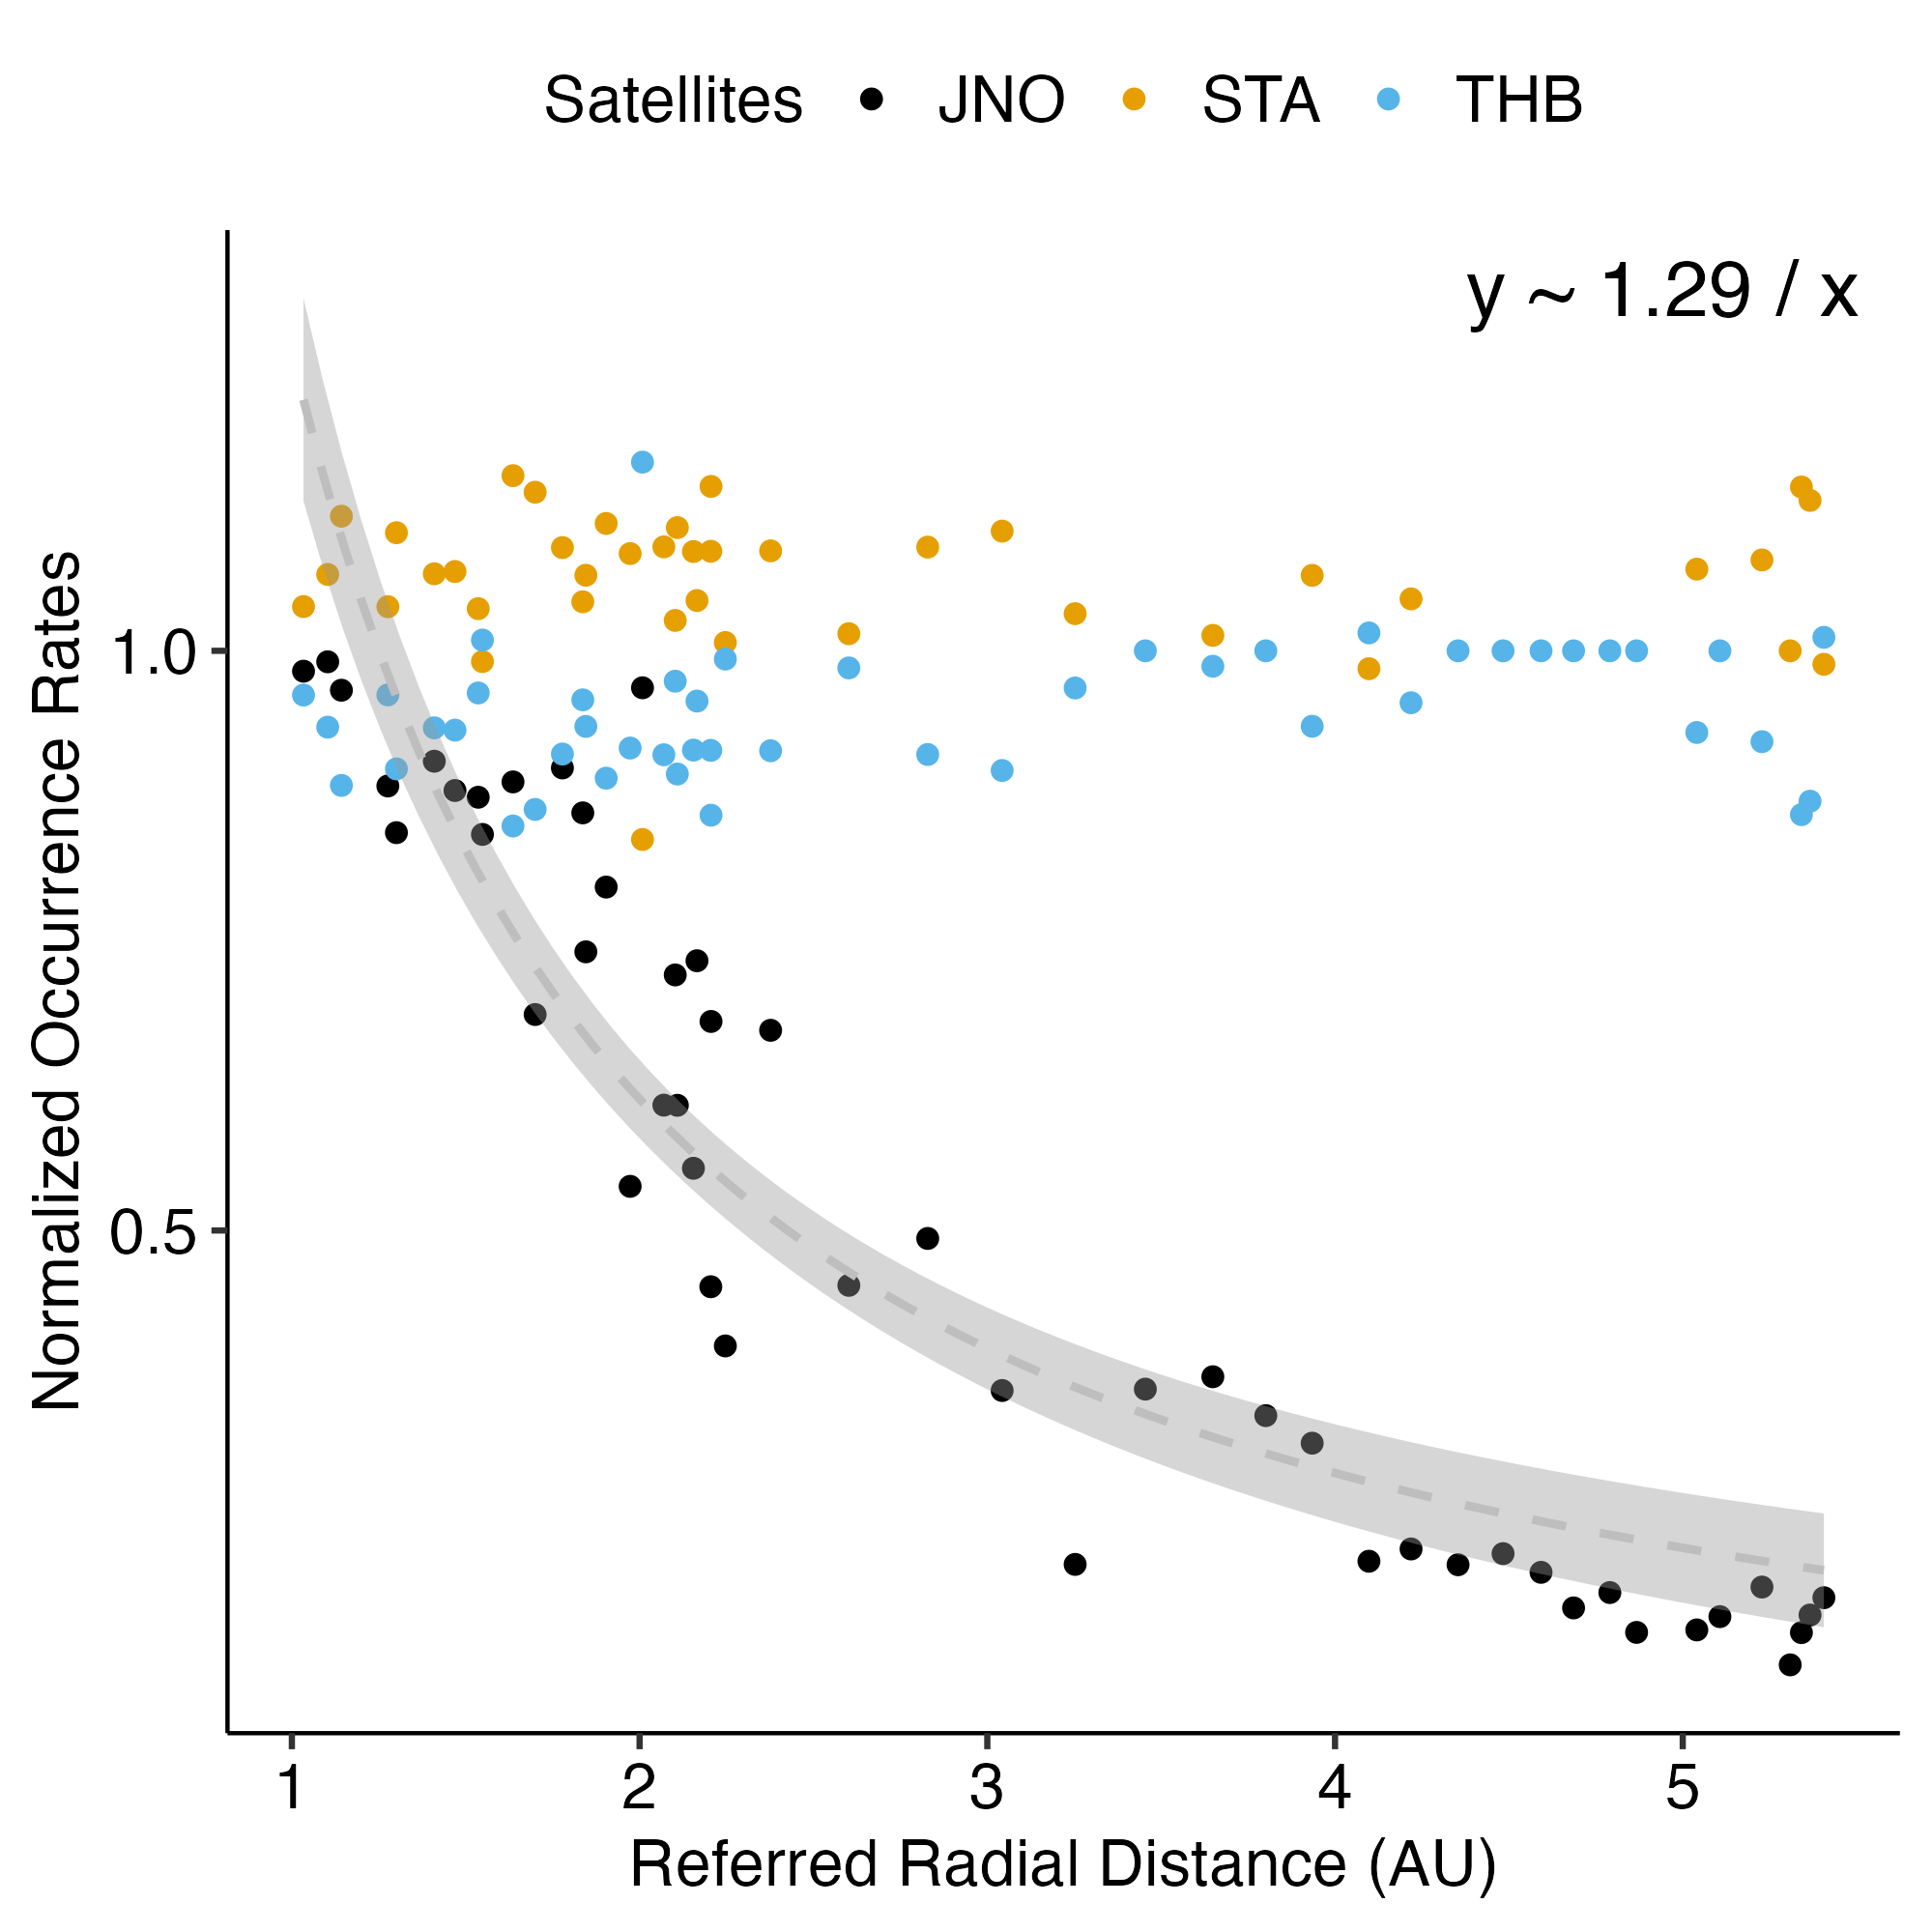</p>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Occurrence rates with time and radial distance

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
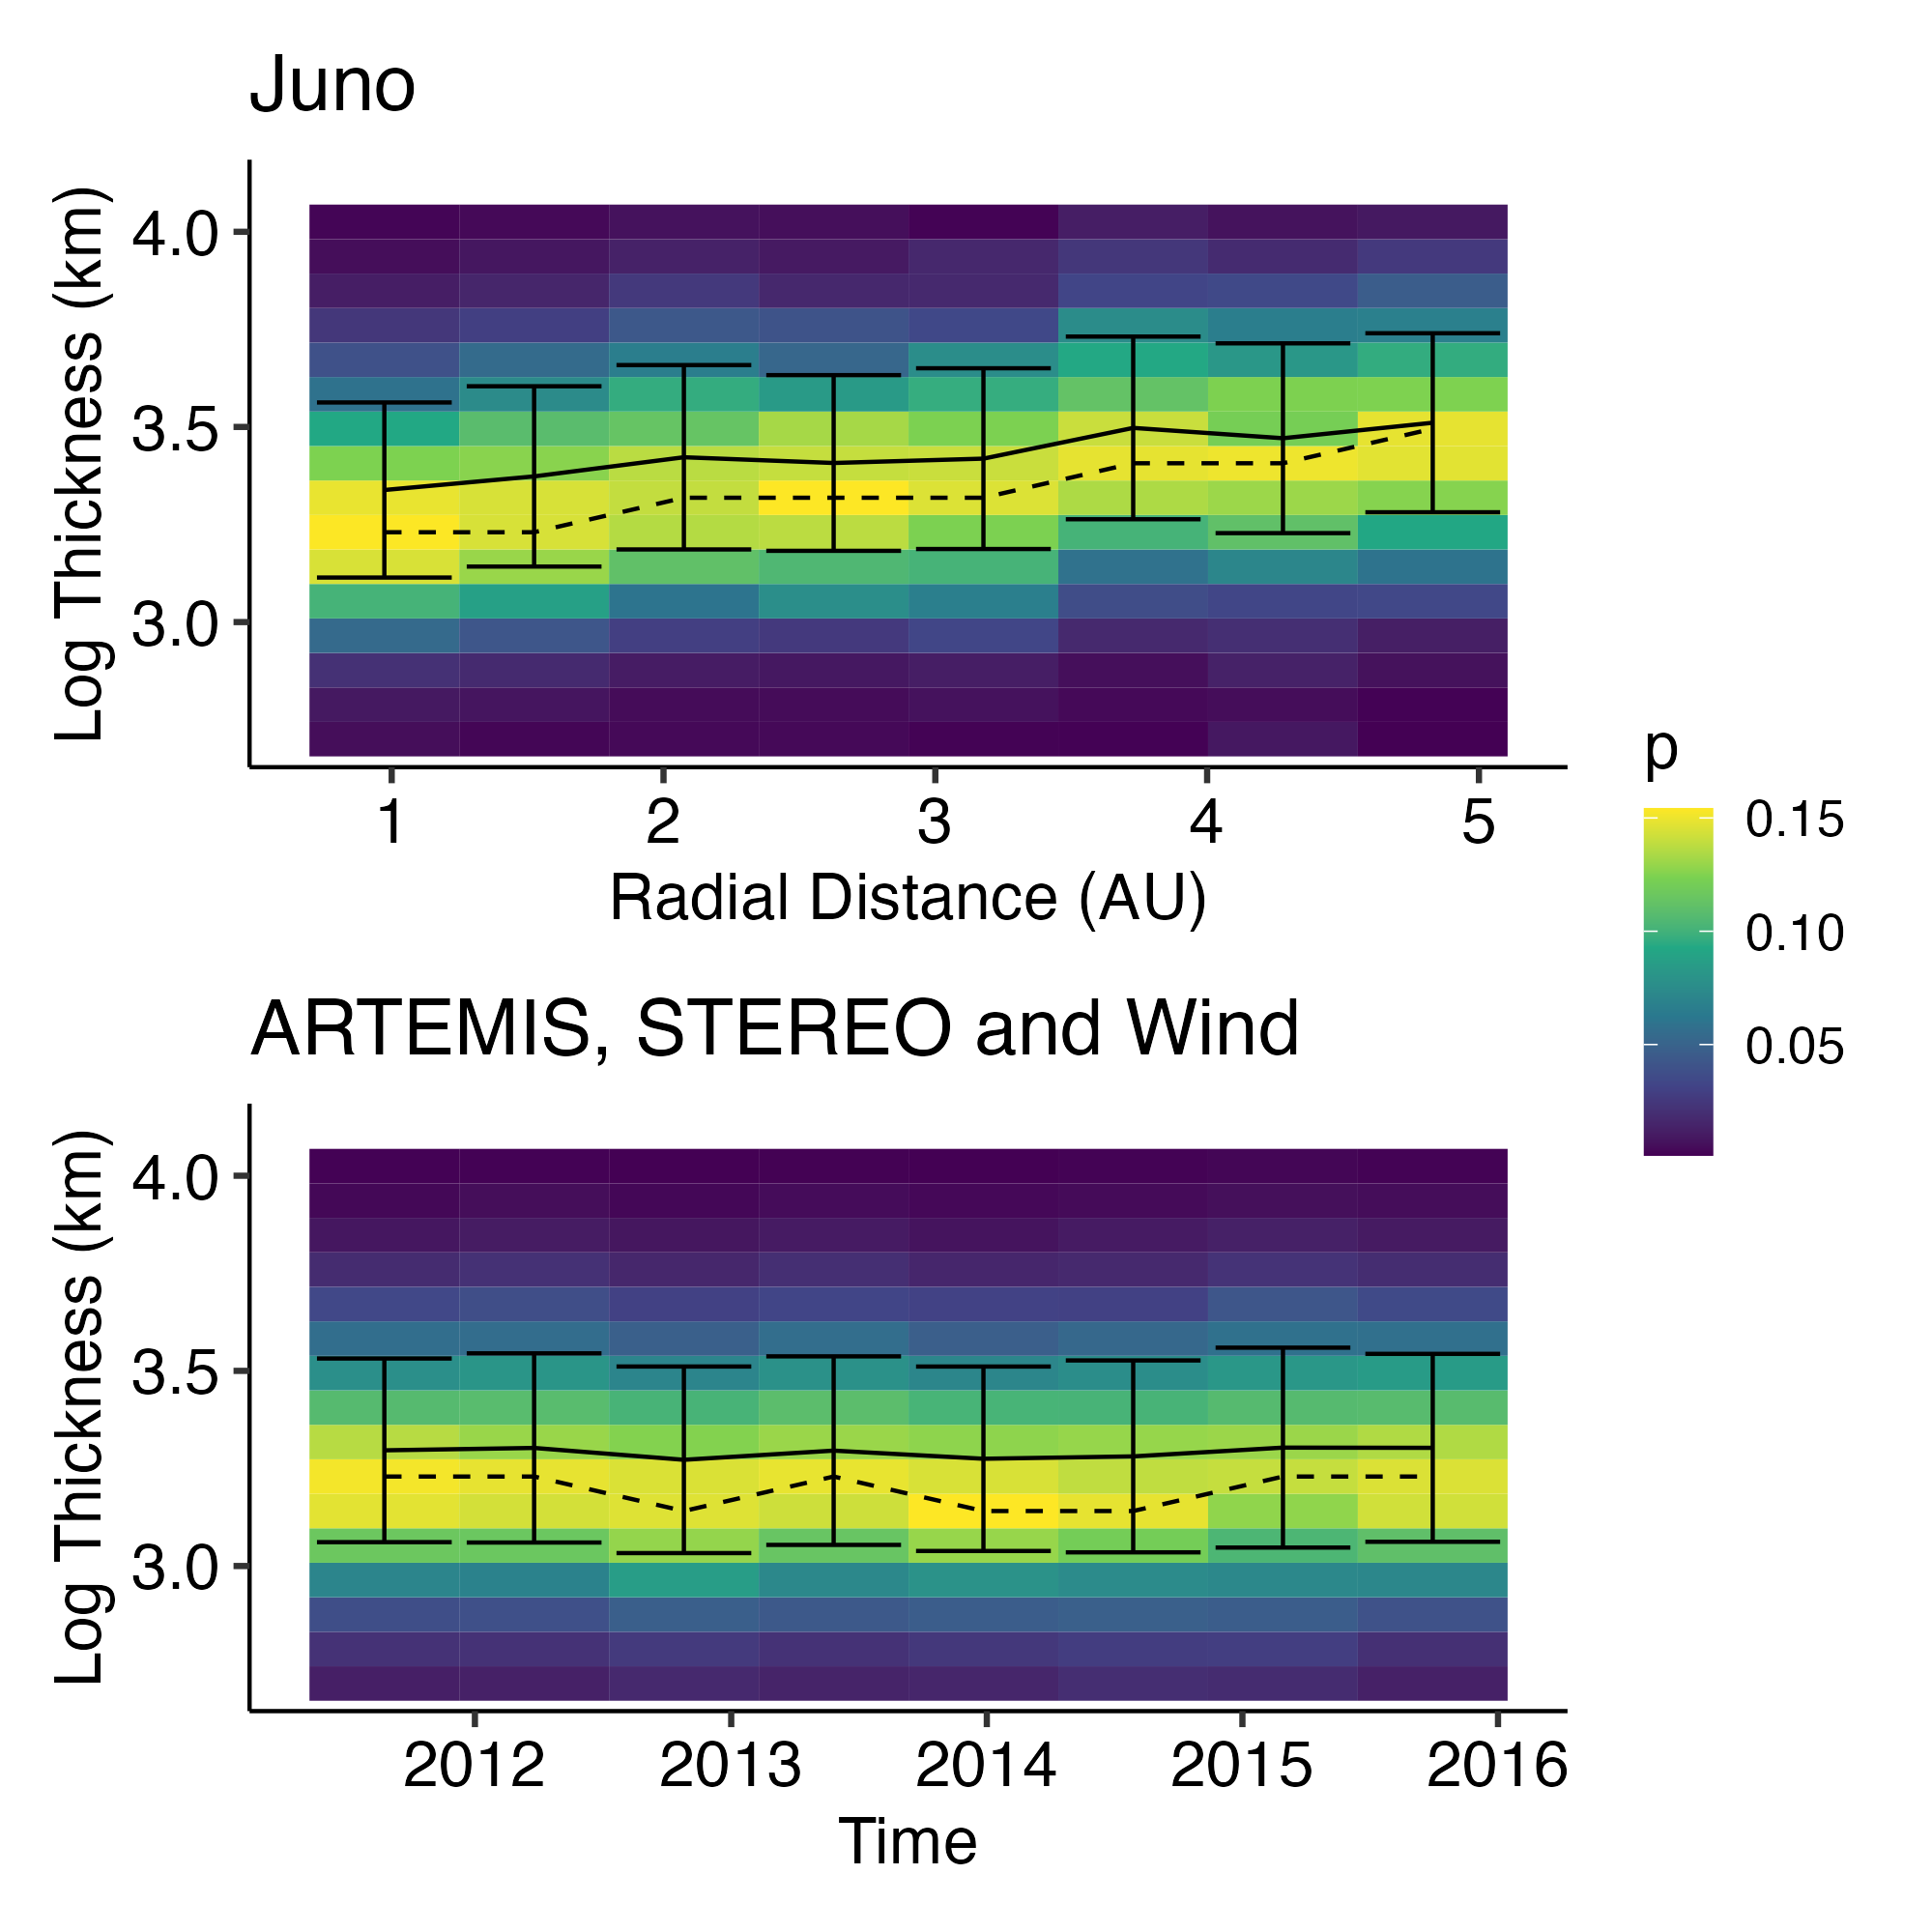
<figcaption aria-hidden="true">MN thickness</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
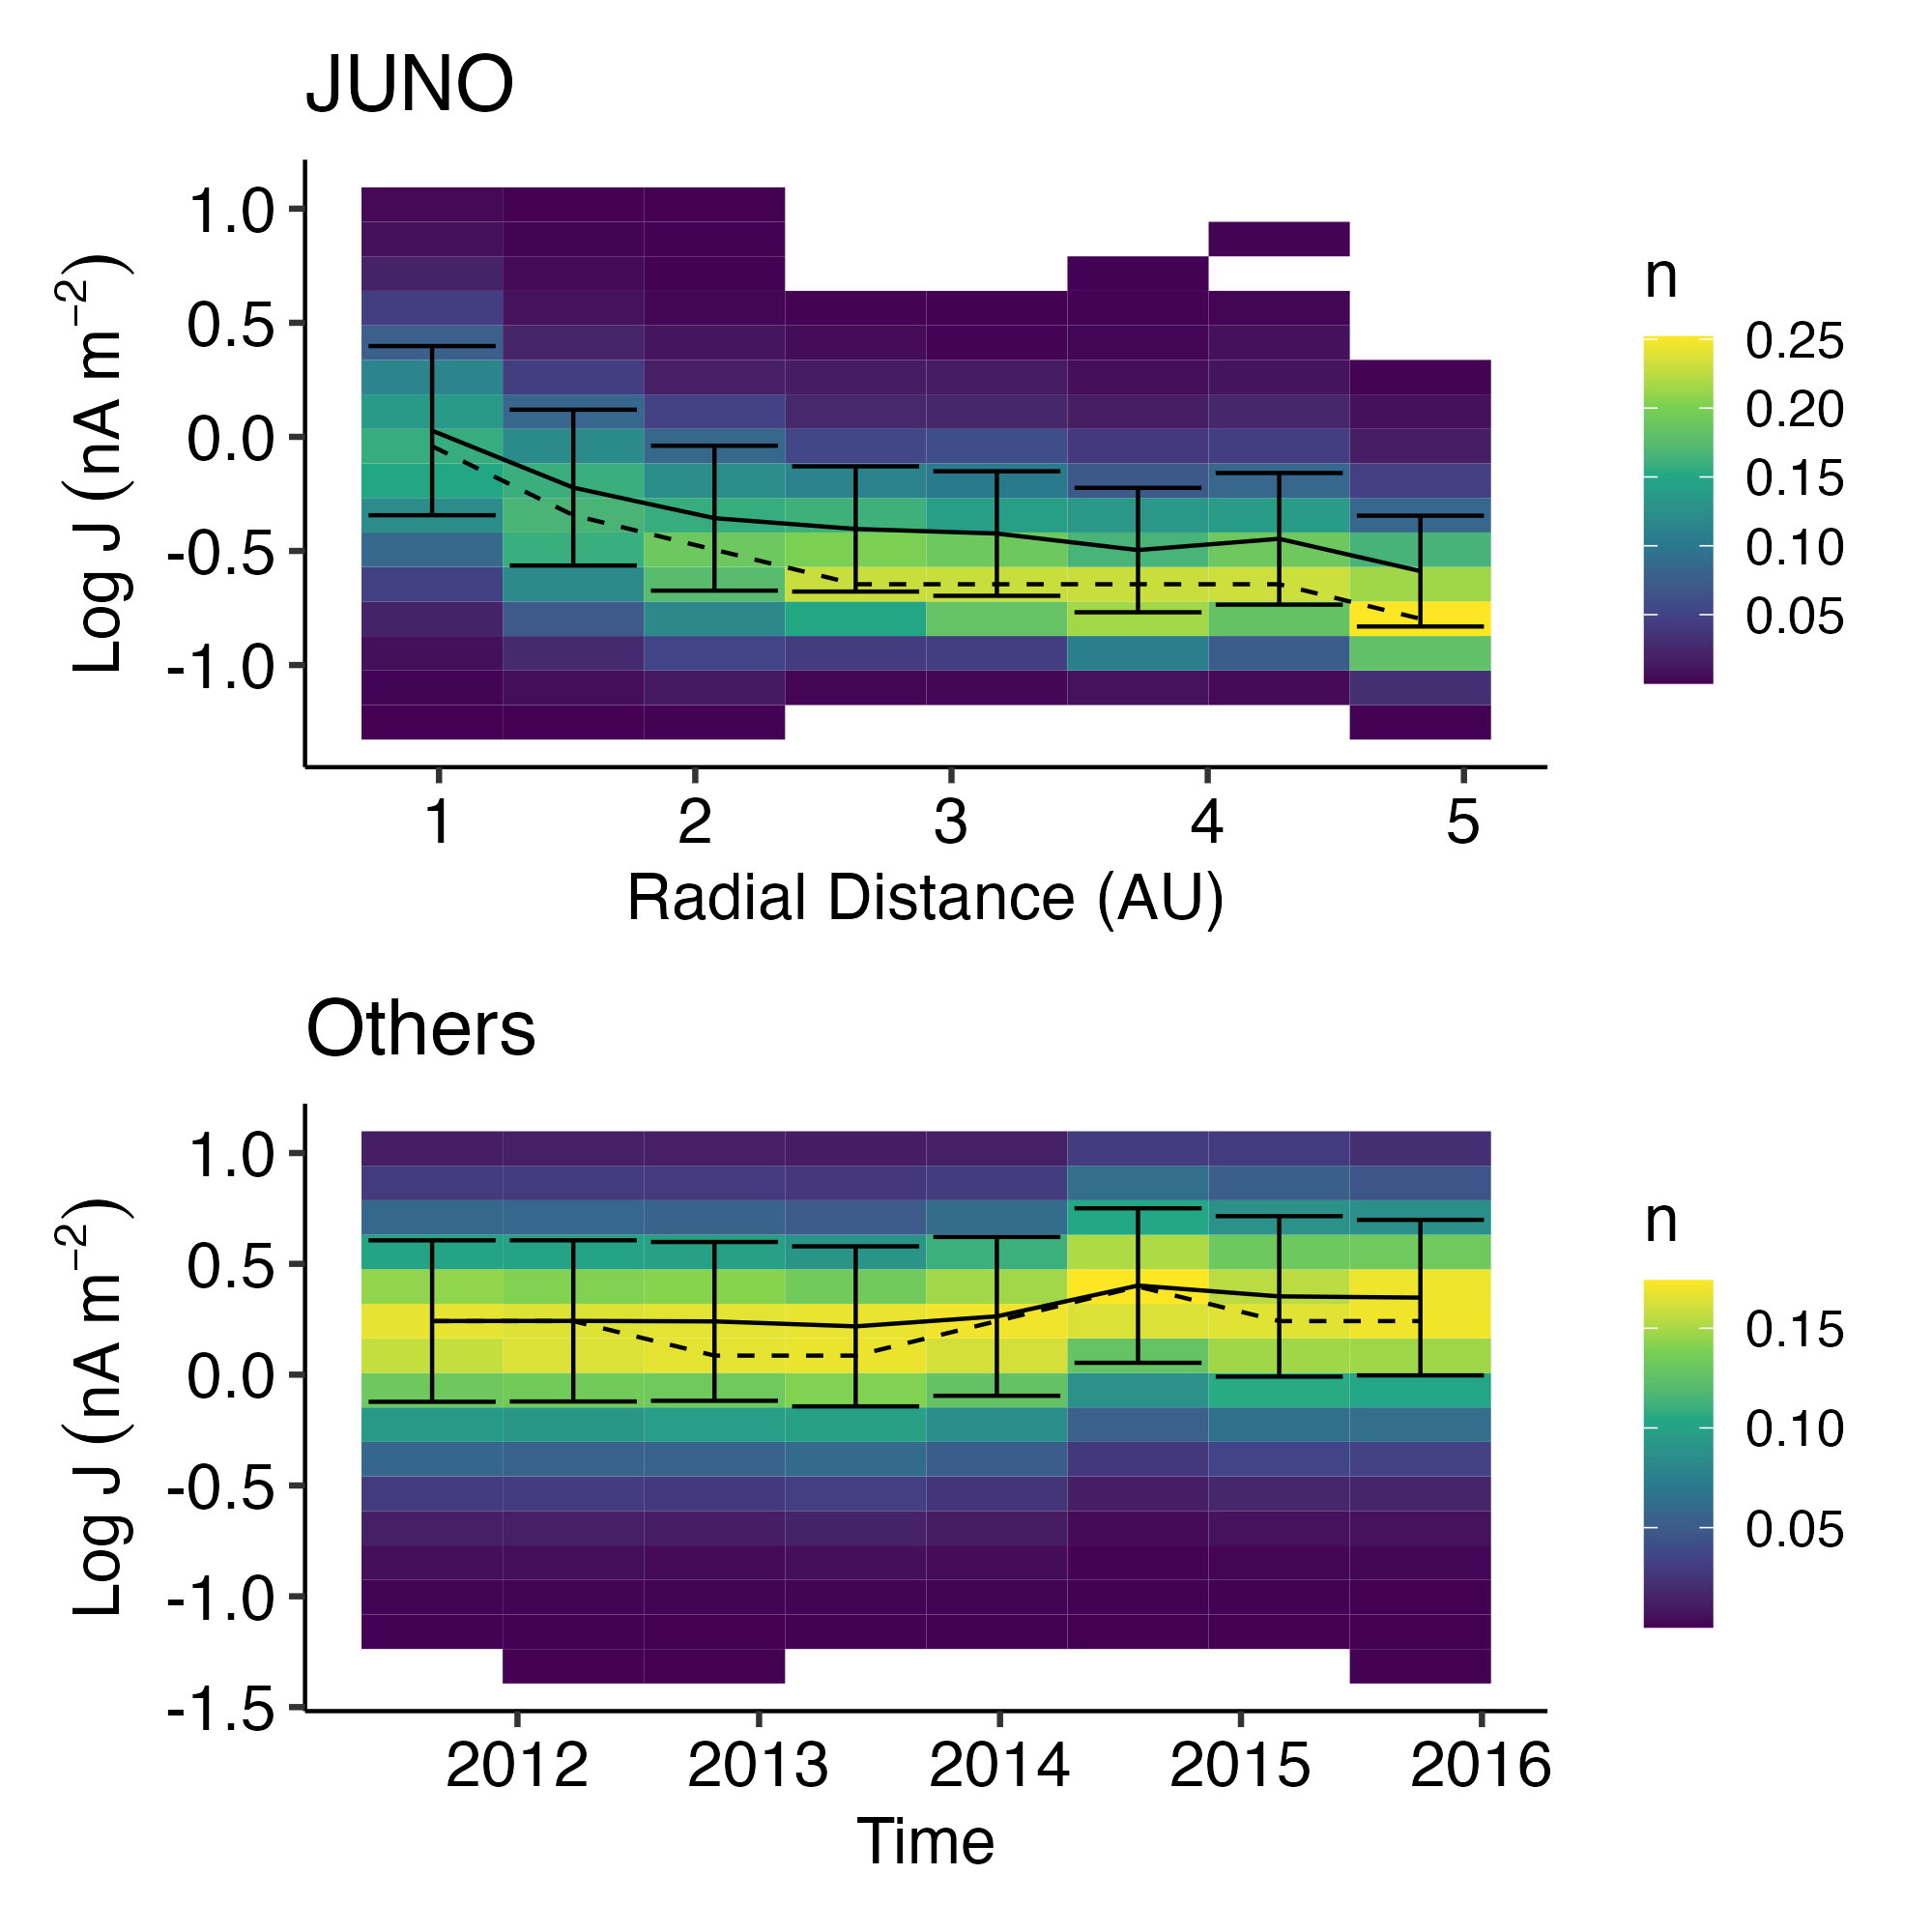
<figcaption aria-hidden="true">MN current</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
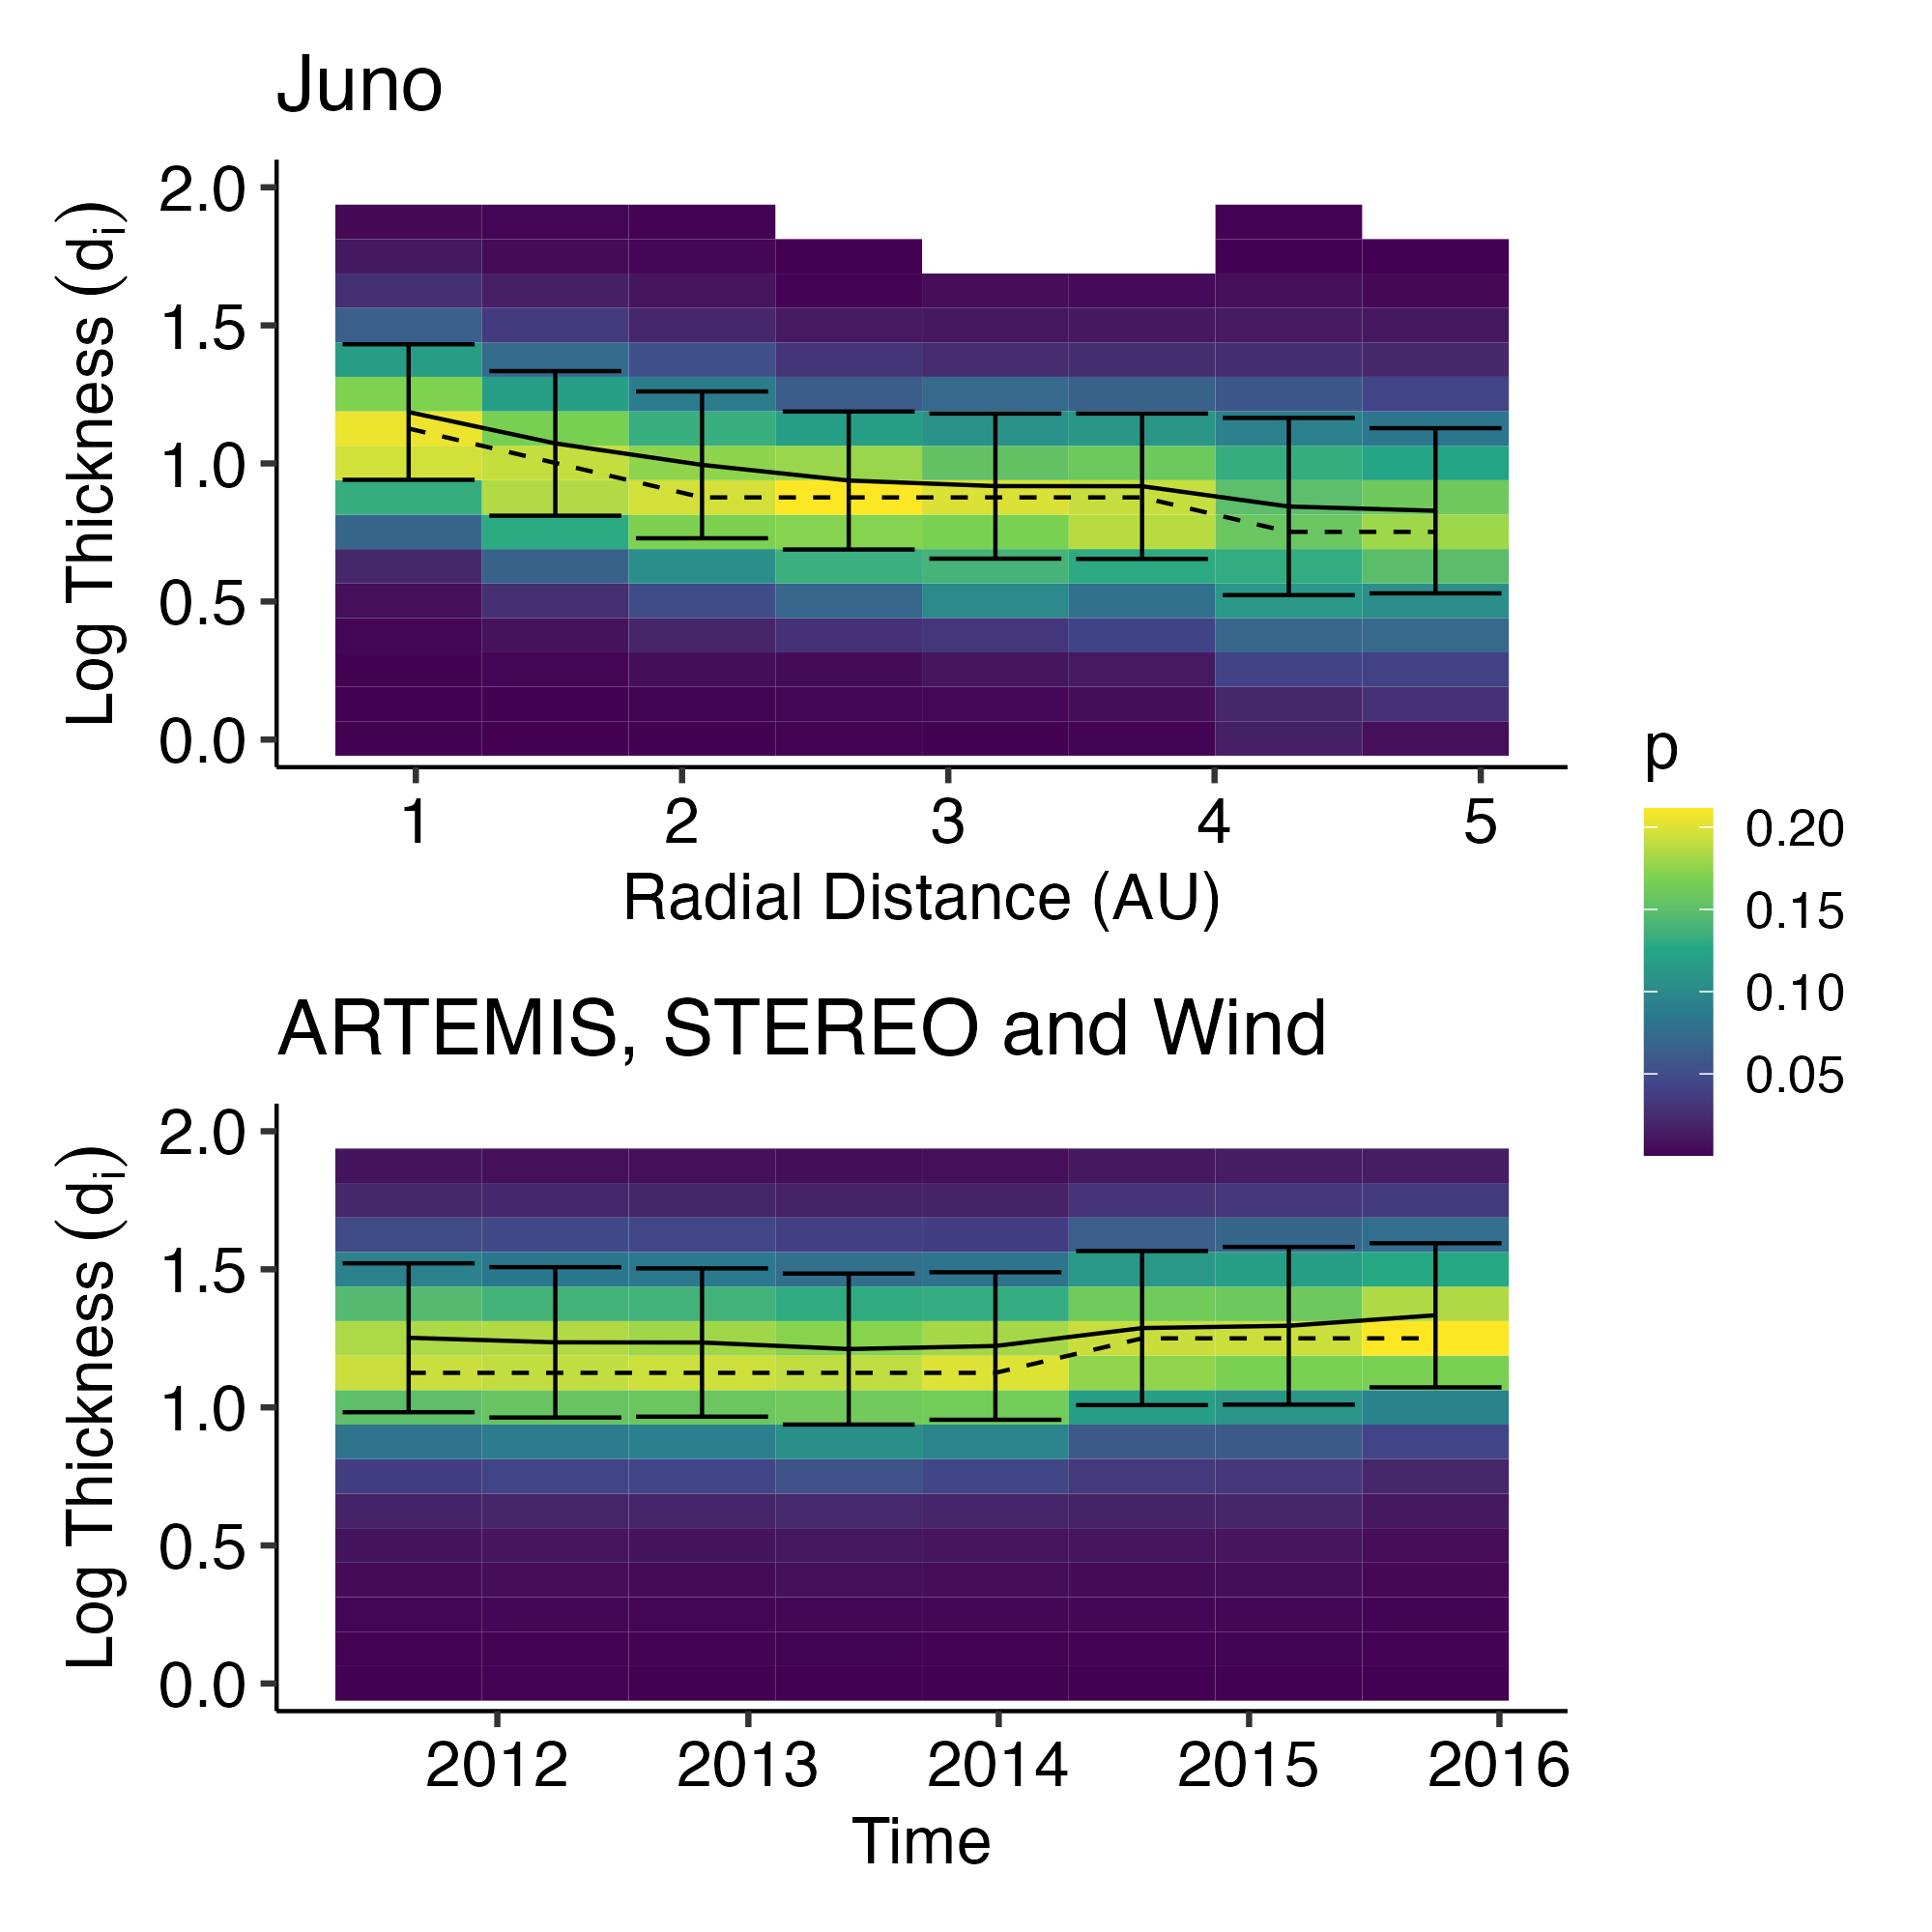
<figcaption aria-hidden="true">MN normalized thickness</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<figure>
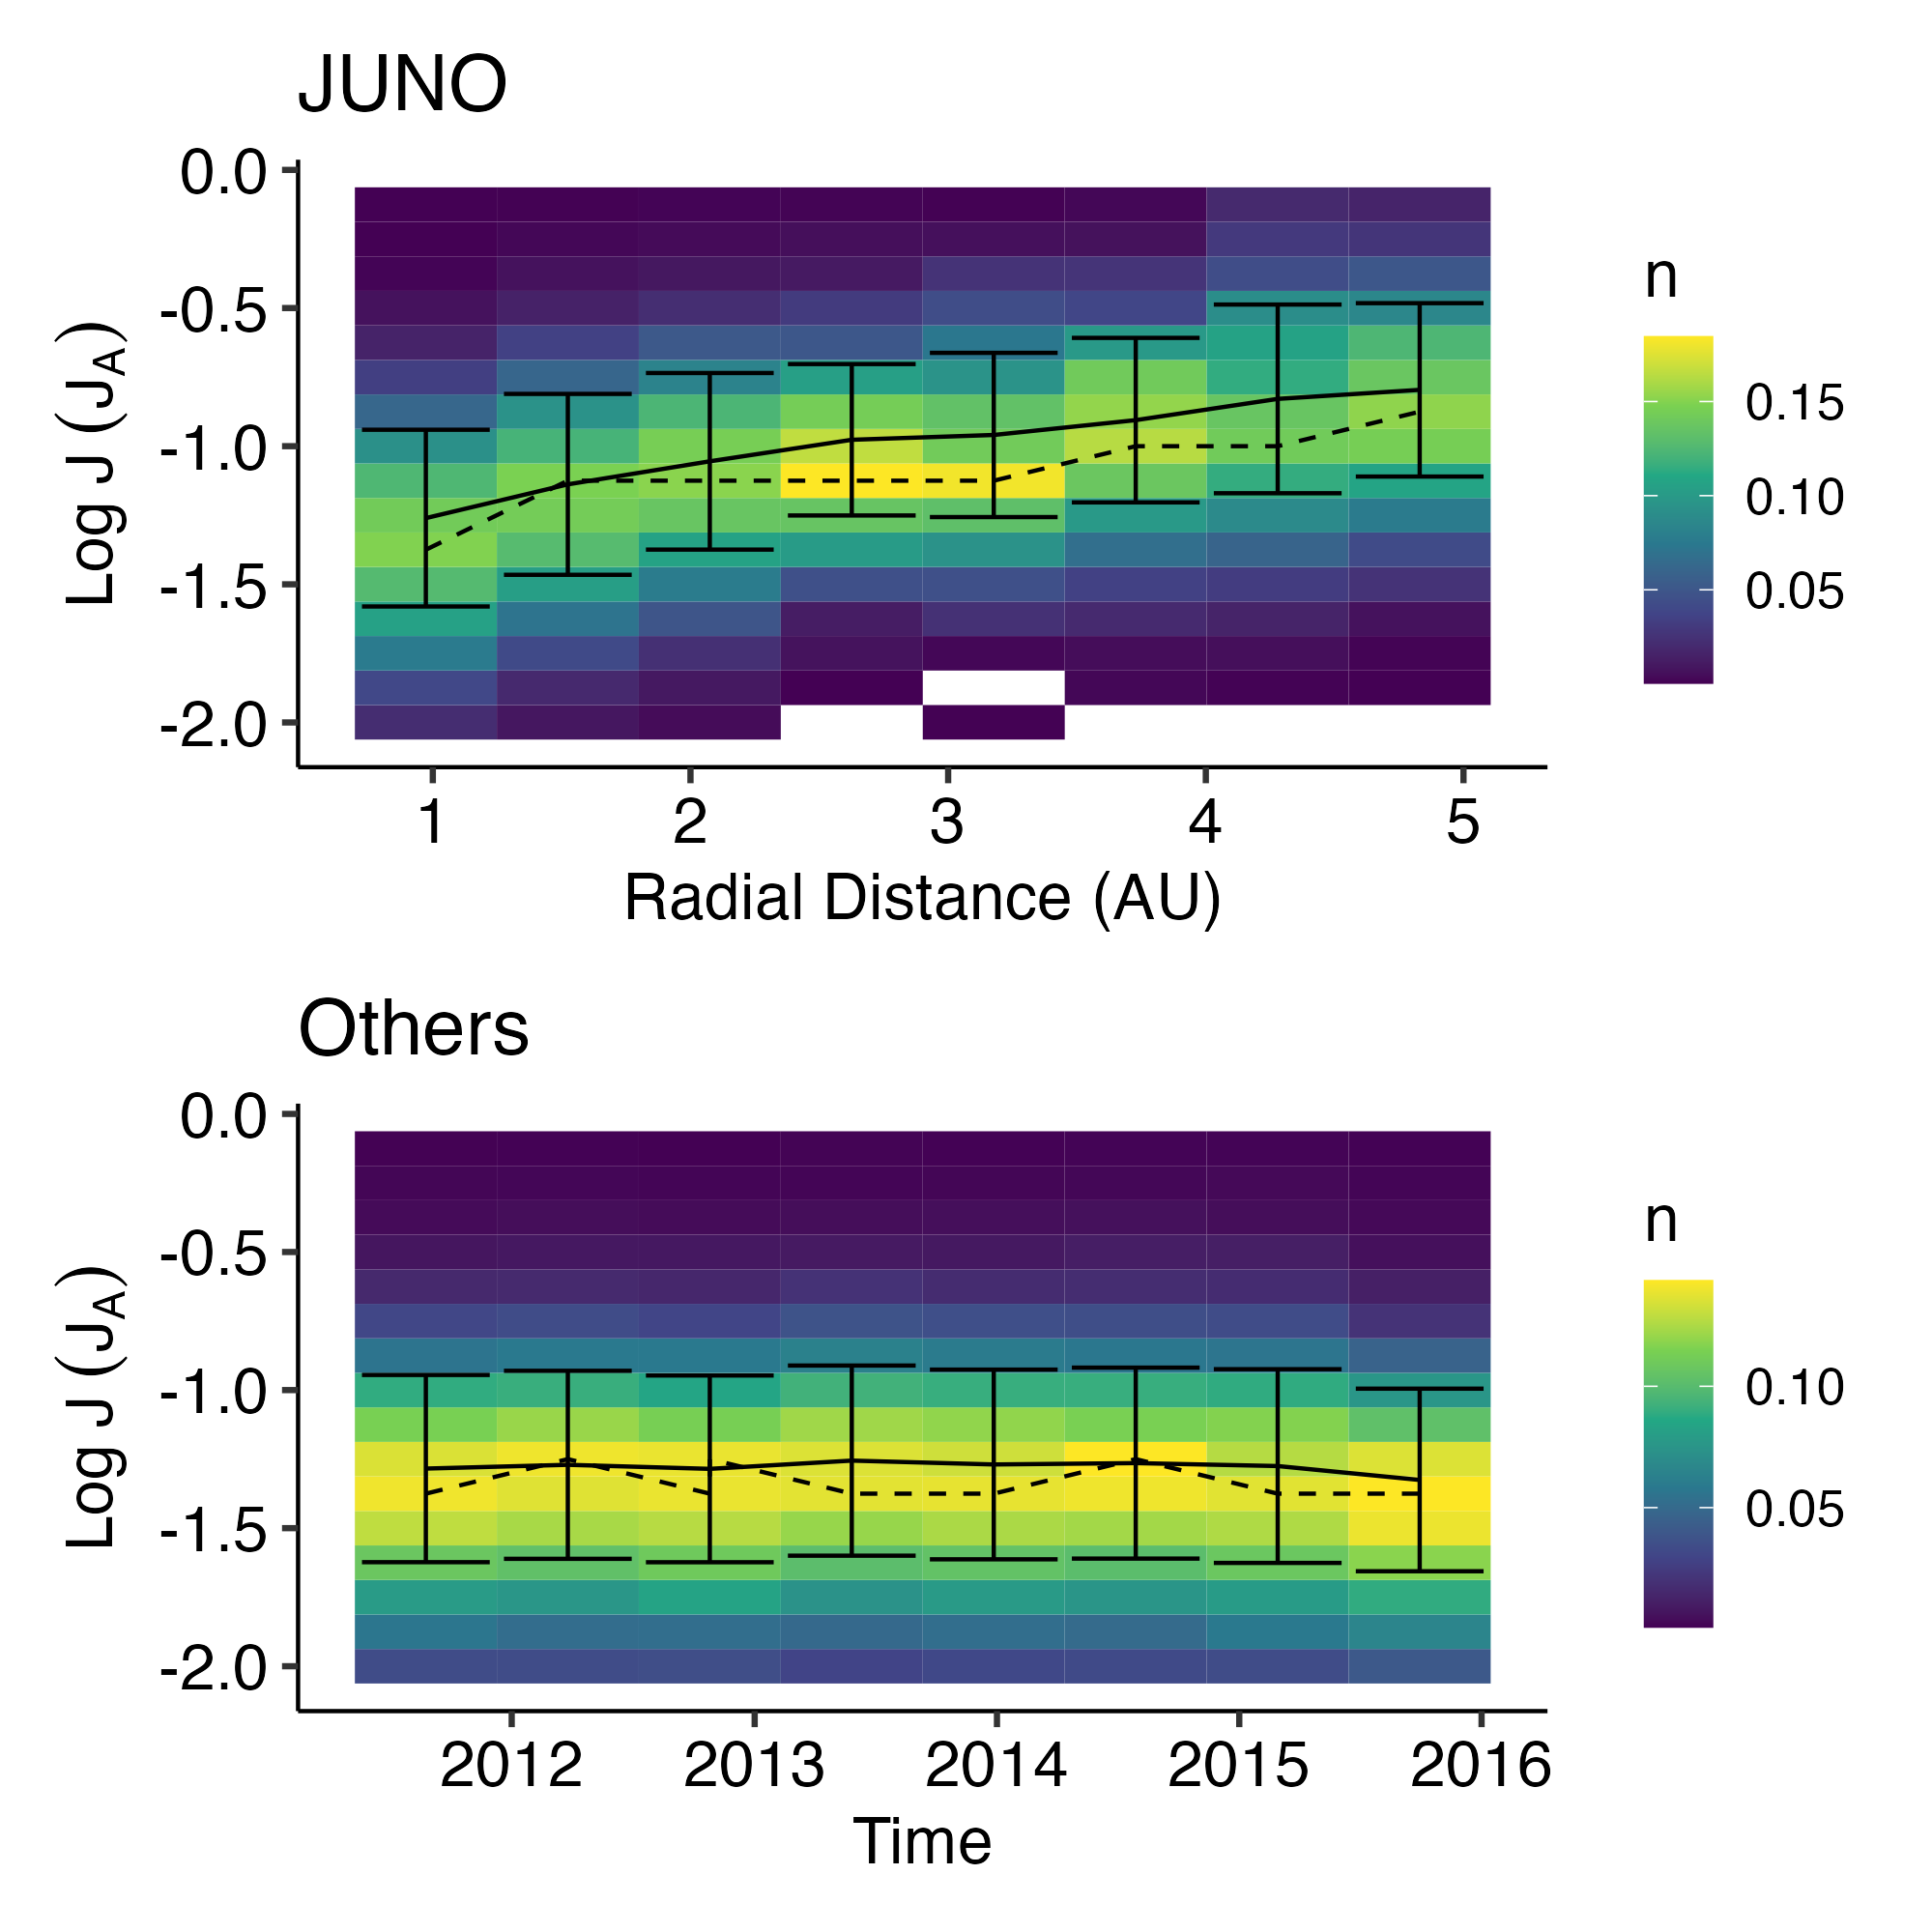
<figcaption aria-hidden="true">MN normalized current</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table style="width:50%;">
<colgroup>
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: left;"><div width="50.0%" data-layout-align="left">
<p>Thickness and current density distribution</p>
</div></td>
</tr>
</tbody>
</table>

# TODOs

Science part

-   Analysis
    -   [ ] Contribution of discontinuities to the power spectrum
    -   [ ] Check Datagap
    -   [ ] Check `ARTEMIS-B` data in different states (solar wind, magnetosheath, magnetotail, moon wake)
    -   [ ] Distribution of \|B\| over radius
    -   [ ] JUNO from 2012-09~2012-10 lack of IDS and extreme large thickness
    -   [ ] Wind data
    -   [ ] Add error bar
    -   [ ] Validate the effects of calibrate candidate duration
    -   [ ] Validate model density with `Voyager`
-   Identifaction
    -   [ ] Ensemble forest?
    -   [ ] Smoothing is important?
    -   [ ] Check change point algorithm
-   Visualize data gaps
-   Features
    -   [ ] Thickness in N direction
    -   [ ] Use high resolution data for feature extraction
-   Compare with other methods of identifying IDs
    -   [ ] Verify with other methods of identifying IDs
-   [x] Incorporate solar wind propagation model
    -   [x] Verify with solar wind propagation model
        -   [x] Coordinate transformation

In [13]:
import yaml
import polars as pl
from functools import reduce
from IPython.display import Markdown
from tabulate import tabulate

with open("data/info.yml", "r") as file:
    data = yaml.safe_load(file)


# Recursive function to find magnetometers
def find_instrument(instruments, ins_type):
    instrument = {}
    for key, value in instruments.items():
        if value.get("type") == ins_type:
            instrument = value
        elif "instruments" in value:
            instrument = find_instrument(value["instruments"], ins_type)
    return instrument


def parse_yaml(data, info, ins_type=None):
    rows = []

    for mission, details in data["missions"].items():
        if ins_type is None:
            rows.append([mission, details.get(info)])
            continue
        instruments = details.get("instruments", {})
        instrument = find_instrument(instruments, ins_type)
        rows.append([mission, instrument.get(info)])

    return pl.DataFrame(rows, schema=["Mission", info])


# Define the merge function
def merge_dfs(left, right, on="Mission", how="outer"):
    return left.join(right, on=on, how=how)


# Parse and display the table
df_mag = parse_yaml(data, "time_resolutions", "magnetometer").rename(
    {"time_resolutions": "$\delta t_B$"}
)
df_plasma = parse_yaml(data, "time_resolutions", "plasma").rename(
    {"time_resolutions": "$\delta t_{plasma}$"}
)
df_r = parse_yaml(data, "radial_coverage").rename({"radial_coverage": "Radial coverage"})
df_time = parse_yaml(data, "launch_date").rename({"launch_date": "Launch date"})
df_link = parse_yaml(data, "website")

df_list = [df_mag, df_plasma, df_r, df_time, df_link]  # Replace with your DataFrames

df_merged = reduce(merge_dfs, df_list)
# df = pd.merge(df1, df2, on='Mission')
Markdown(df_merged.to_pandas().to_markdown(index=False))

Keebler, Timothy B., Gábor Tóth, Bertalan Zieger, and Merav Opher. 2022. “MSWIM2D: Two-Dimensional Outer Heliosphere Solar Wind Modeling.” *Astrophysical Journal Supplement Series* 260 (2): 43. <https://doi.org/10.3847/1538-4365/ac67eb>.